In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib
import mne
import plotly.express as px
import seaborn as sns
import pandas as pd
import xmltodict
import math
from typing import List,Tuple

In [2]:
DEFAULT_CHANNEL_NAMES = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3',       
                         'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1',       
                         'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz',       
                         'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2',       
                         'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 
                         'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'F9', 
                         'F10', 'A1', 'A2']

In [3]:
def mneRawFromHdf5(filepath, have_ch_names, sfreq, first_secs_to_trunc, trig_duration=0, 
                   trig_desc="Unknown", ref_ch=None, emg_ch:List[Tuple[int]]|List[int]=[]):
    # Load data from hdf5 file and create MNE Raw Array
    hf = h5py.File(filepath, 'r')
    #print(hf.keys())
    data_array = np.divide(np.array(hf.get('RawData/Samples')).T,1e6)
    if have_ch_names:
        acq_task_desc = hf.get('RawData/AcquisitionTaskDescription')
        #print(xmltodict.parse(np.array(acq_task_desc)[0])['AcquisitionTaskDescription']['ChannelProperties']['ChannelProperties'])
        ch_num_name_lookup = {}
        ch_props = xmltodict.parse(np.array(acq_task_desc)[0])['AcquisitionTaskDescription']['ChannelProperties']['ChannelProperties']
        for prop in ch_props:
            #print(prop['LogicalChannelNumber']+', '+prop['ChannelName'])
            if prop['ChannelName']:
                ch_num_name_lookup[prop['LogicalChannelNumber']] = prop['ChannelName']
            else: 
                #print(prop['LogicalChannelNumber'])
                if 1 <= int(prop['LogicalChannelNumber']) <= 64:
                    ch_num_name_lookup[prop['LogicalChannelNumber']] = DEFAULT_CHANNEL_NAMES[int(prop['LogicalChannelNumber'])-1]
        
        ch_names = [ch_num_name_lookup[num] for num in ch_num_name_lookup.keys()]
    else:
        ch_names = ['Channel' + str(i + 1) for i in range(data_array.shape[0])]
    
    ch_types = ['eeg' for i in range(data_array[:len(ch_names)].shape[0])]
    array_for_mne = data_array[:len(ch_names)]
    # if there is EMG data contained in the HDF5 file, load the data and add elements into ch_names and ch_types
    for i in range(len(emg_ch)):
        # if the elements are tuples (of two ints), means the EMG channel is bipolar
        # so will need to subtract the values of the first one by the values in the second one
        if type(emg_ch[i]) == tuple:
            # Get the index of the EMG channels in the data array
            emg_ch_idx = [-1,-1]
            j = 0
            for prop in ch_props:
                if int(prop['LogicalChannelNumber']) == emg_ch[i][0]:
                    emg_ch_idx[0] = j
                elif int(prop['LogicalChannelNumber']) == emg_ch[i][1]:
                    emg_ch_idx[1] = j
                
                j += 1
            
            # if not found, raise exception
            if -1 in emg_ch_idx:
                raise ValueError("The channel numbers for the EMG channels can not be found from the HDF5 file provided.")
            print(data_array[emg_ch_idx[0]][:5])
            print(data_array[emg_ch_idx[1]][:5])
            print((data_array[emg_ch_idx[0]]-data_array[emg_ch_idx[1]])[:5])
            array_for_mne = np.vstack((array_for_mne, data_array[emg_ch_idx[0]]-data_array[emg_ch_idx[1]]))
            
        # if the elements are integers, load the data diectly
        elif type(emg_ch[i]) == int:
            # Get the index of the EMG channel in the data array
            emg_ch_idx = -1
            j = 0
            for prop in ch_props:
                if int(prop['LogicalChannelNumber']) == emg_ch[i]:
                    emg_ch_idx = j
                    break
                j += 1
            
            # if not found, raise exception
            if emg_ch_idx == -1:
                raise ValueError("The channel numbers for the EMG channels can not be found from the HDF5 file provided.")
            
            array_for_mne = np.vstack((array_for_mne, data_array[emg_ch_idx]))
        ch_names.append('EMG' + str(i + 1))
        ch_types.append('emg')

    mne_raw_info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)
    mne_raw_arr = mne.io.RawArray(array_for_mne, mne_raw_info)

    

    # Re-reference data if reference channels are given
    if ref_ch:
        mne_raw_arr.set_eeg_reference(ref_channels=ref_ch)

    # Set annotations for triggers
    # Get times of triggers
    trig_times = (hf.get('AsynchronData/Time')[:]/sfreq).squeeze()
    # add anntations into the eeg data array
    durations = np.repeat(trig_duration,len(trig_times))

    if type(trig_desc) == str:
        descriptions = [trig_desc]*len(trig_times)
    elif type(trig_desc) == list:
        descriptions = trig_desc
    #print(descriptions)
    trig_annot = mne.Annotations(trig_times,durations,descriptions)
    mne_raw_arr.set_annotations(trig_annot)
    #print(raw_eeg.annotations)
    # crop the eeg data array for baseline signal removal
    #print(data_array.shape[1]/sfreq)
    mne_raw_arr.crop(tmin=first_secs_to_trunc, tmax=np.floor(data_array.shape[1]/sfreq))

    return mne_raw_arr

In [4]:
#FIRST_SECS_TO_REMOVE = 90
#trig_desc_lst = ['Eye_Close' if (i%2==0) else 'Eye_Open' for i in range(30)]
#re_ref_motor_eeg = mneRawFromHdf5('EEG_data/eye reaction2024.04.15_11.24.09.hdf5', True, 512, FIRST_SECS_TO_REMOVE, 
#                                  trig_desc=trig_desc_lst, ref_ch=['A1','A2'])

#FIRST_SECS_TO_REMOVE = 70
#trig_desc_lst = 'Neck_Left'
#raw_motor_data = mneRawFromHdf5('EEG_data/neck left2024.05.14_12.55.41.hdf5', True, 512, FIRST_SECS_TO_REMOVE, 
#                                trig_desc=trig_desc_lst, emg_ch=[(65,66)])

FIRST_SECS_TO_REMOVE = 100
trig_desc_lst = 'Neck_Right'
raw_motor_data = mneRawFromHdf5('EEG_data/neck right2024.05.14_12.49.16.hdf5', True, 512, FIRST_SECS_TO_REMOVE, 
                                trig_desc=trig_desc_lst, emg_ch=[(67,68)])

[-0.00029243 -0.00702912 -0.02173233 -0.0266964  -0.02684182]
[-0.00011447 -0.00234121 -0.00720679 -0.00885653 -0.00890452]
[-0.00017796 -0.00468791 -0.01452554 -0.01783987 -0.01793731]
Creating RawArray with float64 data, n_channels=35, n_times=184327
    Range : 0 ... 184326 =      0.000 ...   360.012 secs
Ready.


In [5]:
def plotMNEData(mne_data, domain, scaling, plt_x_range, title, x_label, y_label, plt_method, 
                channels=[],show_param_ch=False,save_plt_to='', show_trigger=False, show_plt=False):
    if domain == 'time':
        mne_data_df = mne_data.to_data_frame(scalings=scaling)
    elif domain == 'freq':
        mne_data_df = mne_data.to_data_frame(copy=True)
        # Scaling with 1e12 to micro-volt^2/Hz
        for col in mne_data_df.drop(['freq'],axis=1):
            mne_data_df[col] = mne_data_df[col]*1e12

    if show_param_ch:
        ch_not_to_show = [ch for ch in mne_data.ch_names if ch not in channels]
    else:
        ch_not_to_show = channels
    mne_data_df = mne_data_df[(mne_data_df[domain]>plt_x_range[0]) & (mne_data_df[domain]<plt_x_range[1])]
    if plt_method == 'plotly':
        fig = px.line(mne_data_df, x=domain, y=mne_data_df.drop(columns=[domain]+ch_not_to_show).columns,
                      title=title,labels={domain:x_label, 'value':y_label})
        if show_trigger and domain == 'time':
            for annot in mne_data.annotations:
                trig_x_pos = annot['onset']-FIRST_SECS_TO_REMOVE
                if trig_x_pos > mne_data_df[domain].iloc[0] and trig_x_pos < mne_data_df[domain].iloc[-1]:
                    fig.add_vline(x=trig_x_pos, line_width=1, line_dash="dash", line_color="green",
                                  annotation_text=f"{trig_x_pos:.2f}", annotation_position="top right")
        
        if save_plt_to:
            fig.write_html(save_plt_to)
        if show_plt:
            fig.show()
    
    elif plt_method == 'pyplot':
        plt.figure(figsize=(16, 15))
        #print(mne_data_df.drop(columns=[domain]+ch_not_to_show).head())
        plt.plot(mne_data_df[domain], mne_data_df.drop(columns=[domain]+ch_not_to_show))
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend(mne_data_df.drop(columns=[domain]+ch_not_to_show).columns, loc="best", prop={'size': 8})

        if show_trigger and domain == 'time':
            for annot in mne_data.annotations:
                trig_x_pos = annot['onset']-FIRST_SECS_TO_REMOVE
                if trig_x_pos > mne_data_df[domain].iloc[0] and trig_x_pos < mne_data_df[domain].iloc[-1]:
                    plt.axvline(x=trig_x_pos, color='r', linestyle='--')
                    # Show the value of the asynchron time, on the top of the lin
                    plt.text(trig_x_pos, plt.ylim()[1], f"{trig_x_pos:.2f}", rotation=45, verticalalignment='top')

                    
        if save_plt_to:
            plt.savefig(save_plt_to)
        if show_plt:
            plt.show()

In [6]:
def plotMNEArrSubplots(mne_eeg_arr,scaling,title,channel_names,time_range = (0,0),figure_size = (10,18),sfreq = 512, show_trigger=False):
    #plot the eeg data in four subplots(divide data into four parts)
    #display partial time only works for dataframe data

    eeg_df = mne_eeg_arr.to_data_frame(scalings=scaling)
    if time_range == (0,0):
        selected_time_data = eeg_df
    else:
        start,end = time_range
        selected_time_data = eeg_df[(eeg_df['time']>=start) & (eeg_df['time']<=end)]
    x = selected_time_data['time']
    y = selected_time_data.iloc[:,1:]

    #plt.figure(figsize=fig_size)
    fig, axs = plt.subplots(4,figsize= figure_size)
    fig.suptitle(title, y = 0.99)
    num_channels  = len(channel_names)
    NUM_COLORS = math.ceil(num_channels/4)
    num_remaining_channels = num_channels - (3*NUM_COLORS)
    sub_titles = ['First {} Channels'.format(NUM_COLORS),'Second {} Channels'.format(NUM_COLORS),'Third {} Channels'.format(NUM_COLORS),\
                   'Remaining {} Channels'.format(num_remaining_channels)]
    #cm = plt.get_cmap('gist_rainbow')
    colors = plt.cm.Spectral(np.linspace(0,1,NUM_COLORS))
    for i in range(4):
        axs[i].set_prop_cycle(color=colors)
        axs[i].plot(x,y.iloc[:,i*NUM_COLORS:(i+1)*NUM_COLORS])
        axs[i].set_title(sub_titles[i])
        axs[i].legend(channel_names[i*NUM_COLORS:(i+1)*NUM_COLORS],loc = 'upper right')
        axs[i].set_xlabel('Time [s]')
        axs[i].set_ylabel('Microvolts [mV]')

        if show_trigger:
            for annot in mne_eeg_arr.annotations:
                trig_x_pos = annot['onset']-FIRST_SECS_TO_REMOVE
                if trig_x_pos > eeg_df['time'].iloc[0] and trig_x_pos < eeg_df['time'].iloc[-1]:
                    axs[i].axvline(x=trig_x_pos, linewidth=1)
    fig.tight_layout()
    plt.show()

In [7]:
[ annot['onset'] for annot in raw_motor_data.annotations]

[117.021484,
 133.105469,
 149.1875,
 167.304688,
 183.371094,
 201.45507800000001,
 217.537109,
 233.603516,
 249.703125,
 265.804688,
 281.90429700000004,
 297.98632799999996,
 315.052734,
 331.119141,
 348.203125]

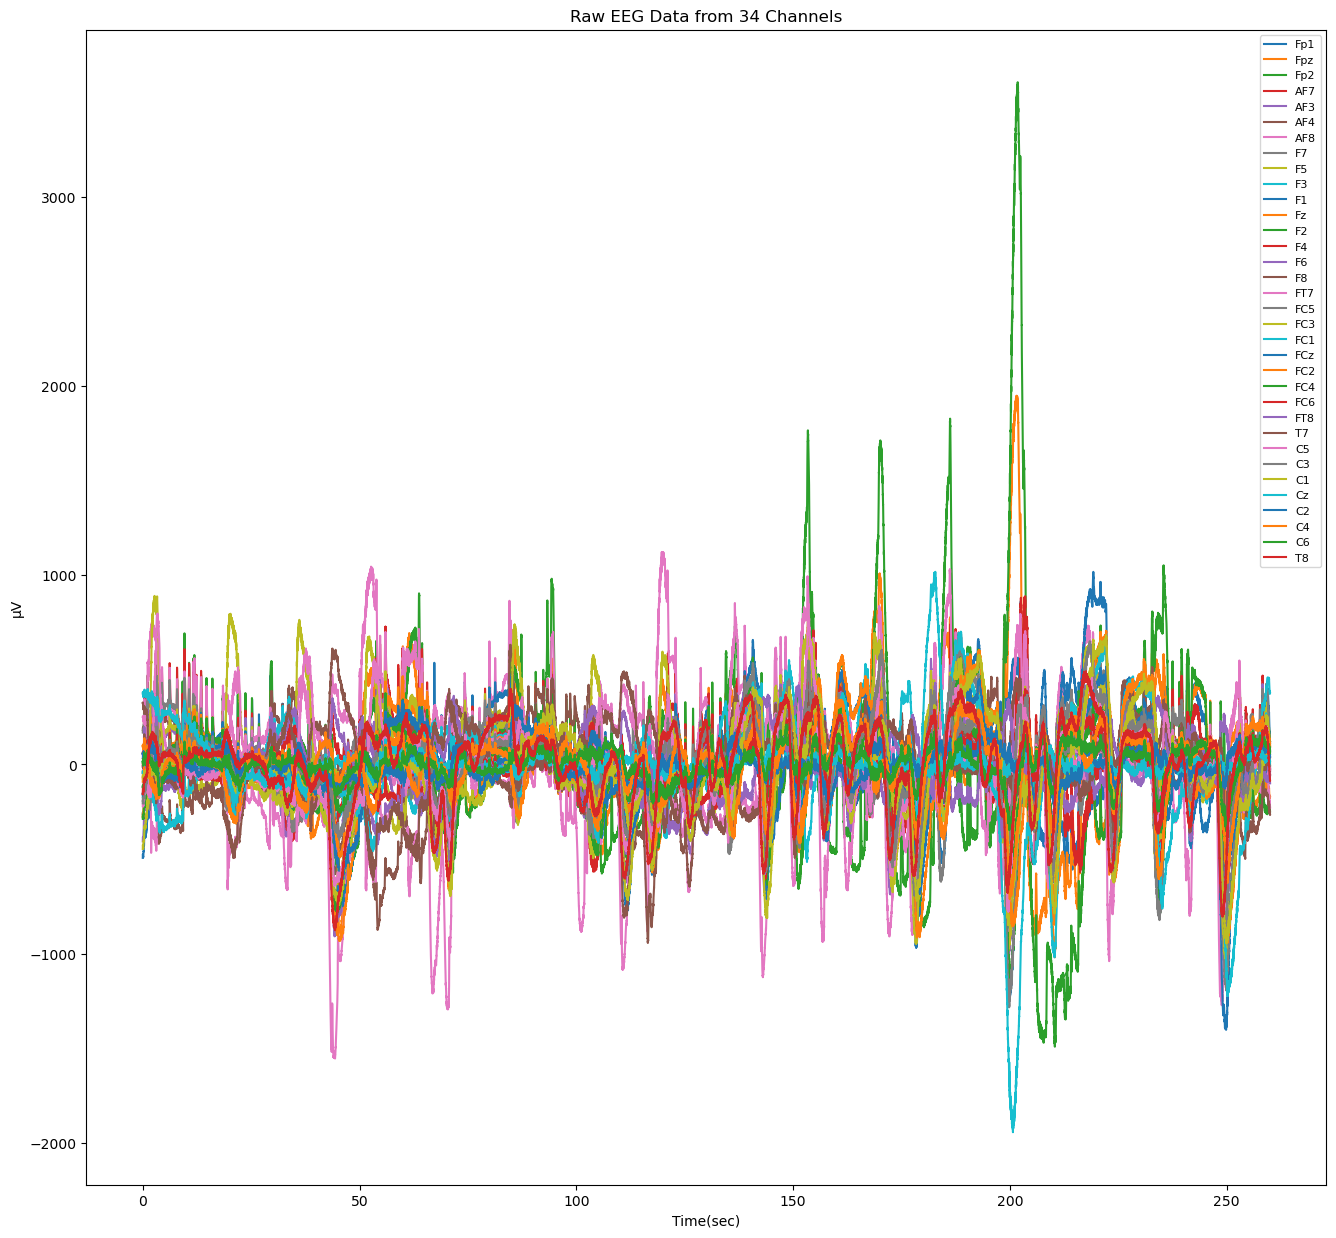

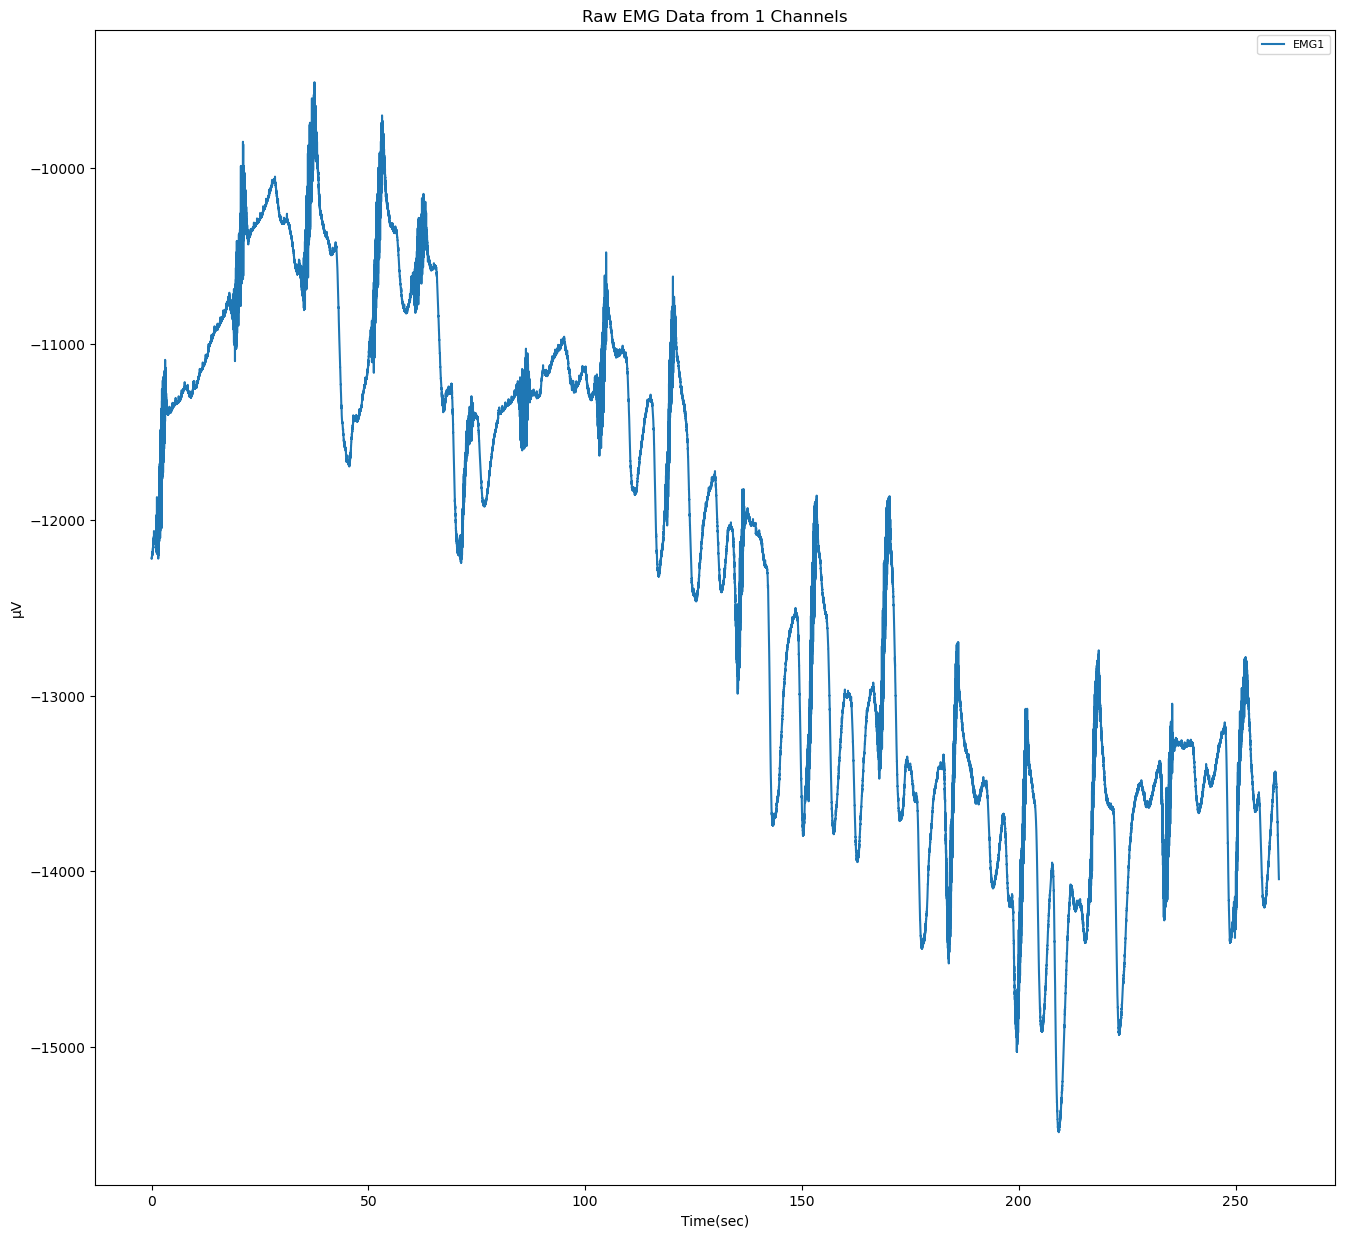

In [10]:
# For eye reaction2024.04.15_11
#plotMNEData(mne_data=re_ref_motor_eeg, domain='time', scaling=1e6, plt_x_range=(0,300),
#            title='Eyes Reaction Raw EEG Data from %d Channels'%(len(re_ref_motor_eeg.ch_names)), 
#            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
#            save_plt_to='motor_raw_eeg.png', show_trigger=False, show_plt=True)

# For neck left/right2024.05.14_12
re_ref_motor_eeg = raw_motor_data.copy().pick(['eeg'])
raw_motor_emg = raw_motor_data.copy().pick(['emg'])
plotMNEData(mne_data=re_ref_motor_eeg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Raw EEG Data from %d Channels'%(len(re_ref_motor_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='motor_raw_eeg.png', show_trigger=False, show_plt=True)
plotMNEData(mne_data=raw_motor_emg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Raw EMG Data from %d Channels'%(len(raw_motor_emg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='motor_raw_emg.png', show_trigger=False, show_plt=True)

In [8]:
def badChByCutoff(mne_eeg_arr, scaling, cutoff_amplitude, cutoff_ratio):
    eeg_df = mne_eeg_arr.to_data_frame(scalings=scaling)
    amp_volts = eeg_df.iloc[:,1:].abs()
    
    exceed_val_counts = amp_volts[amp_volts>=cutoff_amplitude].count()
    exceed_val_counts = exceed_val_counts[exceed_val_counts>0]
    #print(exceed_val_counts)
    
    exceed_val_ratio = (exceed_val_counts/len(eeg_df)).sort_values(ascending = True)
    #print(exceed_val_ratio)
    
    bad_channels = list(exceed_val_ratio[exceed_val_ratio>=cutoff_ratio].index)
    print(bad_channels)
    
    eeg_arr_dropped_bad_ch = mne_eeg_arr.copy().drop_channels(ch_names=bad_channels)
    return eeg_arr_dropped_bad_ch

In [11]:
# For eye reaction2024.04.15_11.24.09
#motor_eeg_wo_bad_ch = badChByCutoff(re_ref_motor_eeg, 1e6, 500, 0.003)

# For neck left2024.05.14_12
#motor_eeg_wo_bad_ch = badChByCutoff(re_ref_motor_eeg, 1e6, 500, 0.3)

# For neck right2024.05.14_12
motor_eeg_wo_bad_ch = badChByCutoff(re_ref_motor_eeg, 1e6, 500, 0.15)

['FC3', 'Fp2', 'AF8']


In [12]:
def badChByStd(mne_eeg_arr, scaling, std_tolerance=None):
    eeg_df = mne_eeg_arr.to_data_frame(scalings=scaling)
    sorted_std_ch = eeg_df.iloc[:,1:].std().sort_values(ascending = False)
    
    mean_of_std = sorted_std_ch.mean()
    print('mean value of channel std',mean_of_std)
    std_of_std = sorted_std_ch.std()
    print('std of channel std',std_of_std)
    print(sorted_std_ch[:10])

    if not std_tolerance:
        std_tolerance = std_of_std*0.1
        
    bad_channels = list(sorted_std_ch[sorted_std_ch>=(mean_of_std+3*std_of_std+std_tolerance)].index)
    print(bad_channels)
    
    eeg_arr_dropped_bad_ch = mne_eeg_arr.copy().drop_channels(ch_names=bad_channels)
    return eeg_arr_dropped_bad_ch

In [13]:
motor_eeg_wo_bad_ch = badChByStd(motor_eeg_wo_bad_ch, 1e6)

mean value of channel std 211.83982655093934
std of channel std 76.49677106773008
Fpz    359.922697
FC1    347.404382
F1     342.477666
F2     295.299453
Fz     284.478642
AF3    284.390495
F8     278.907493
FC5    274.672050
AF7    265.433042
FC2    257.071072
dtype: float64
[]


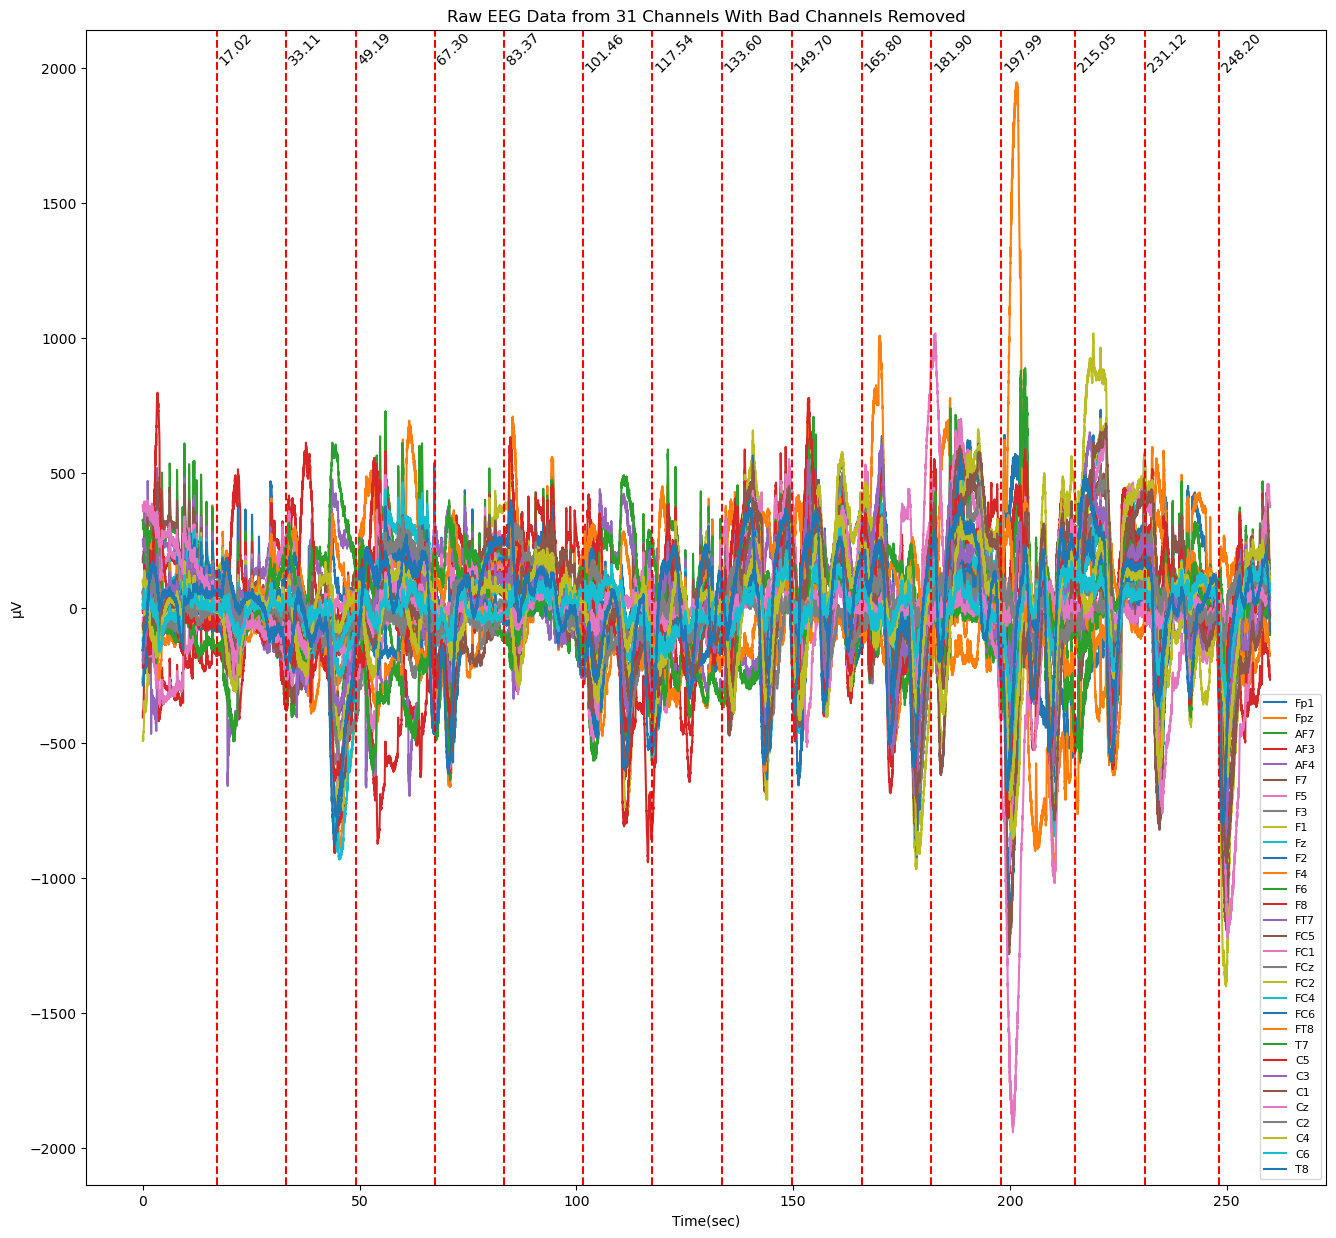

In [13]:
plotMNEData(mne_data=motor_eeg_wo_bad_ch, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Raw EEG Data from %d Channels With Bad Channels Removed'%(len(motor_eeg_wo_bad_ch.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='motor_eeg_wo_bad_ch.png', show_trigger=True, show_plt=True)

In [14]:
# Band-pass and Notch filters for EEG data
low_cut = 1
hi_cut  = 30
filtered_motor_eeg = motor_eeg_wo_bad_ch.copy().filter(low_cut,hi_cut)
filtered_motor_eeg = filtered_motor_eeg.copy().notch_filter(60, method='fir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [15]:
# For HDF5 files with EMG data in the recording
# Band-pass and Notch filters for EMG data
low_cut = 30
hi_cut  = 50
filtered_motor_emg = raw_motor_data.copy().filter(low_cut,hi_cut,picks=['emg'])
filtered_motor_emg = filtered_motor_emg.copy().notch_filter(60, method='fir').pick(['emg'])

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 227 samples (0.443 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband e

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


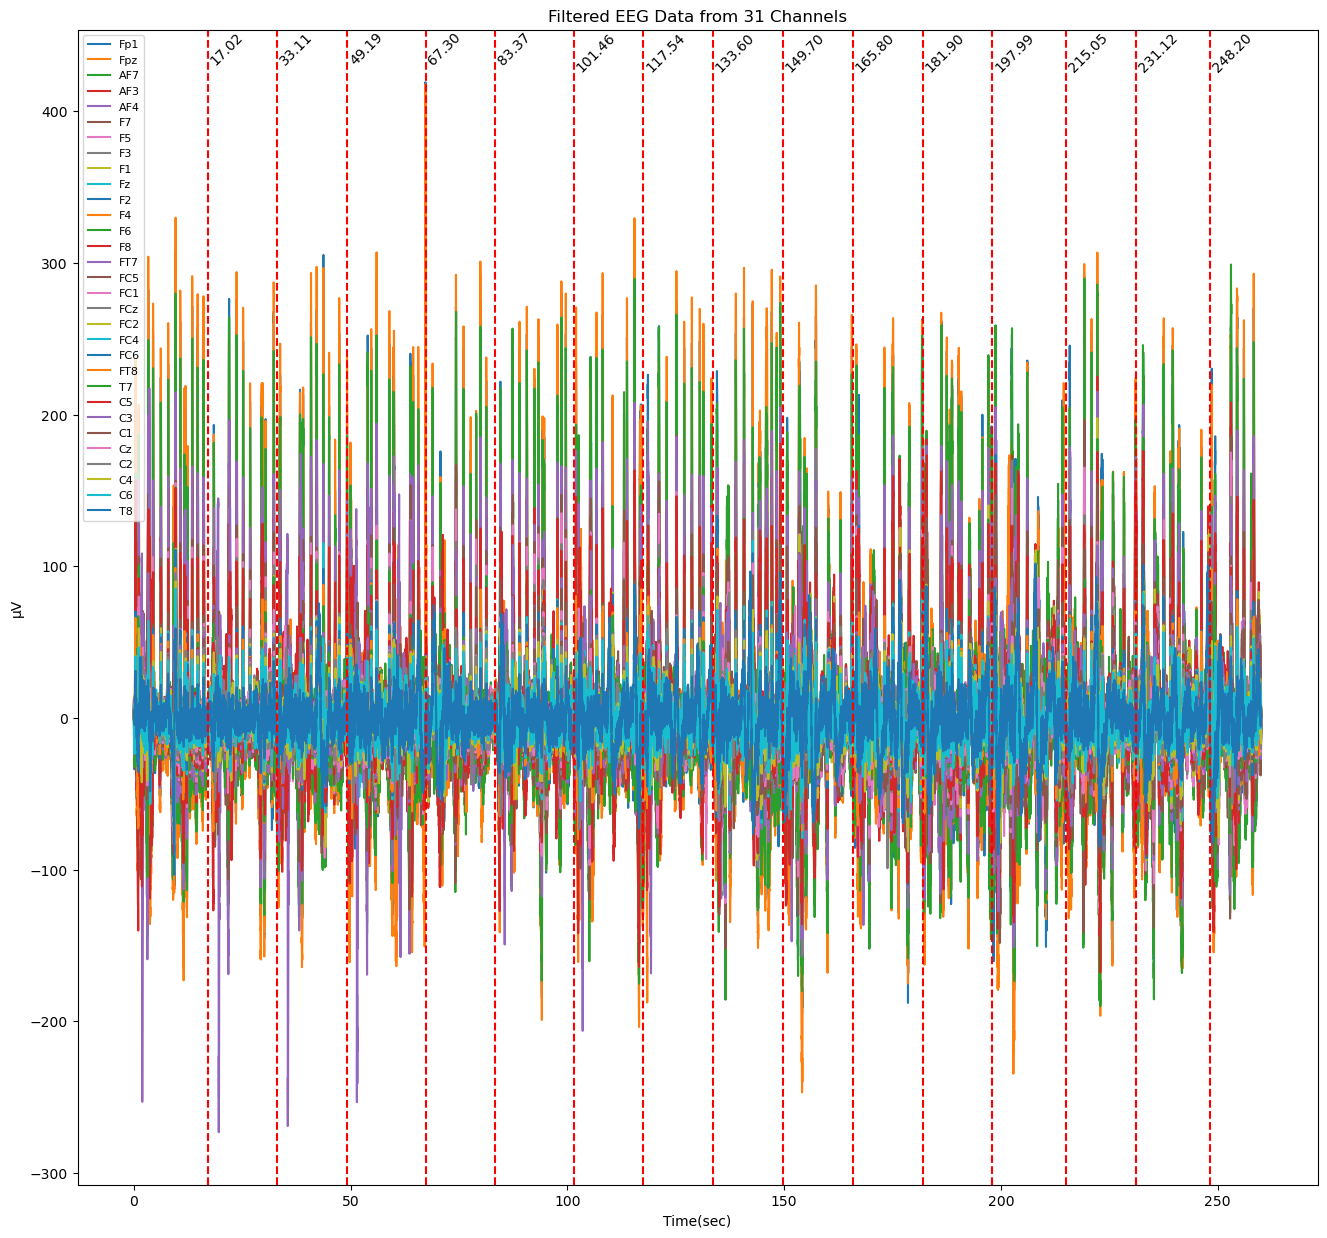

In [16]:
plotMNEData(mne_data=filtered_motor_eeg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Filtered EEG Data from %d Channels'%(len(filtered_motor_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='filtered_motor_eeg.png', show_trigger=True, show_plt=True)

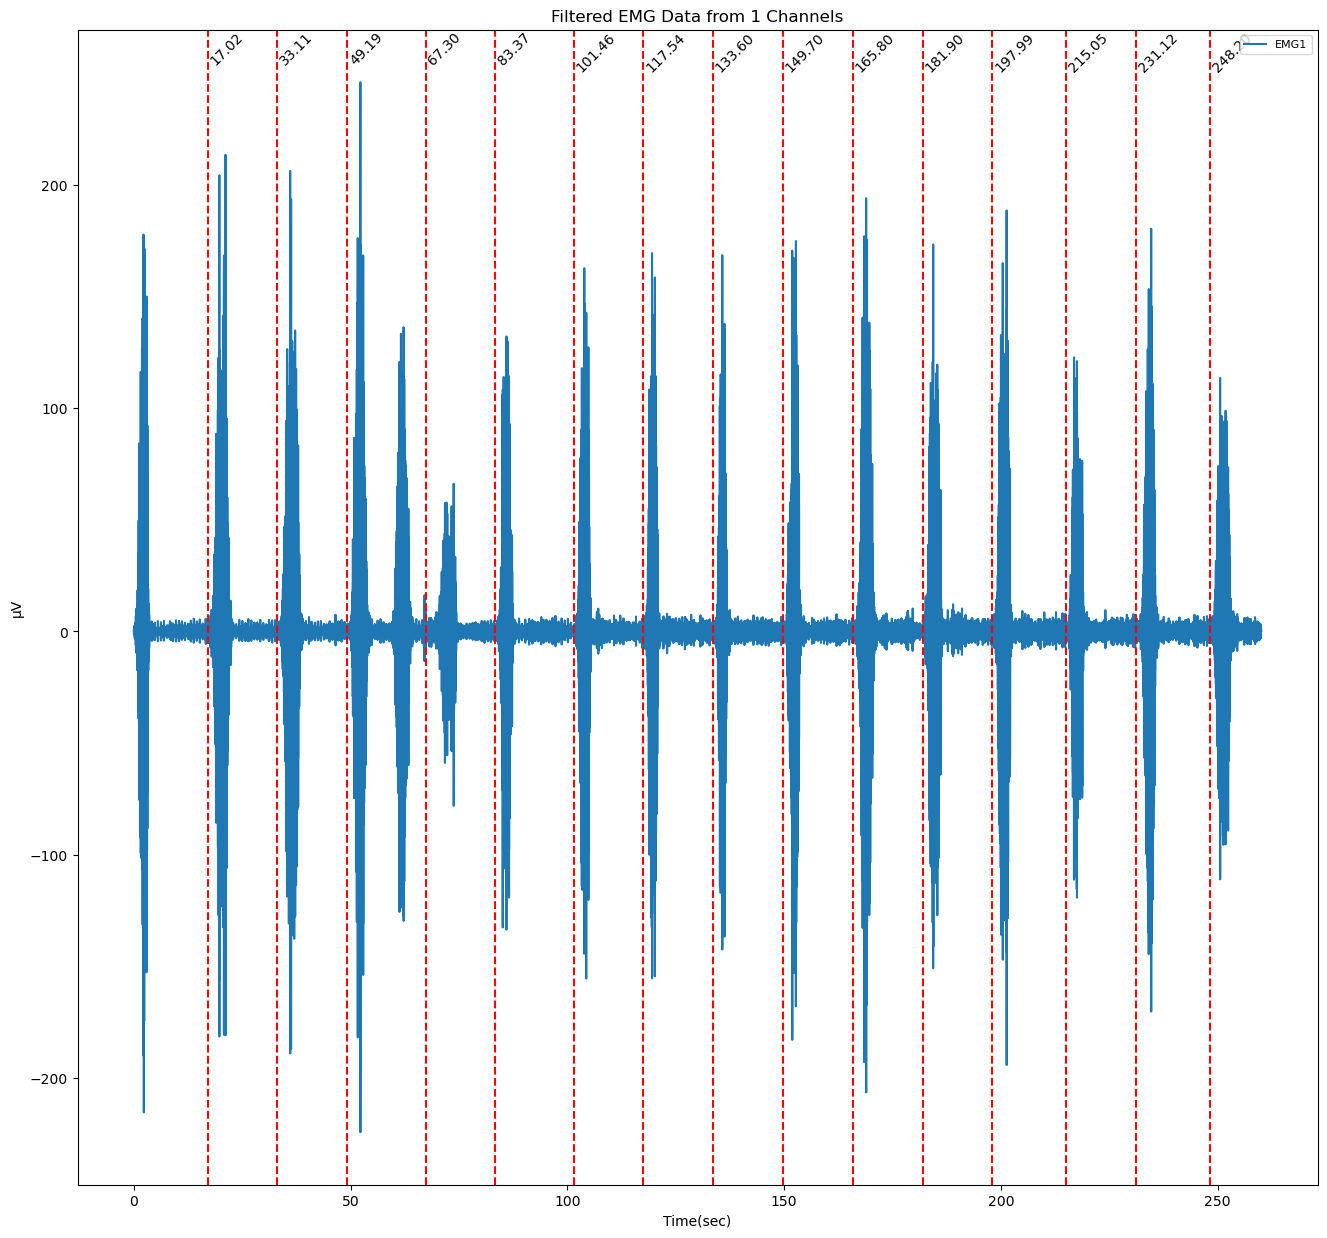

In [17]:
plotMNEData(mne_data=filtered_motor_emg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Filtered EMG Data from %d Channels'%(len(filtered_motor_emg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='filtered_motor_emg.png', show_trigger=True, show_plt=True)

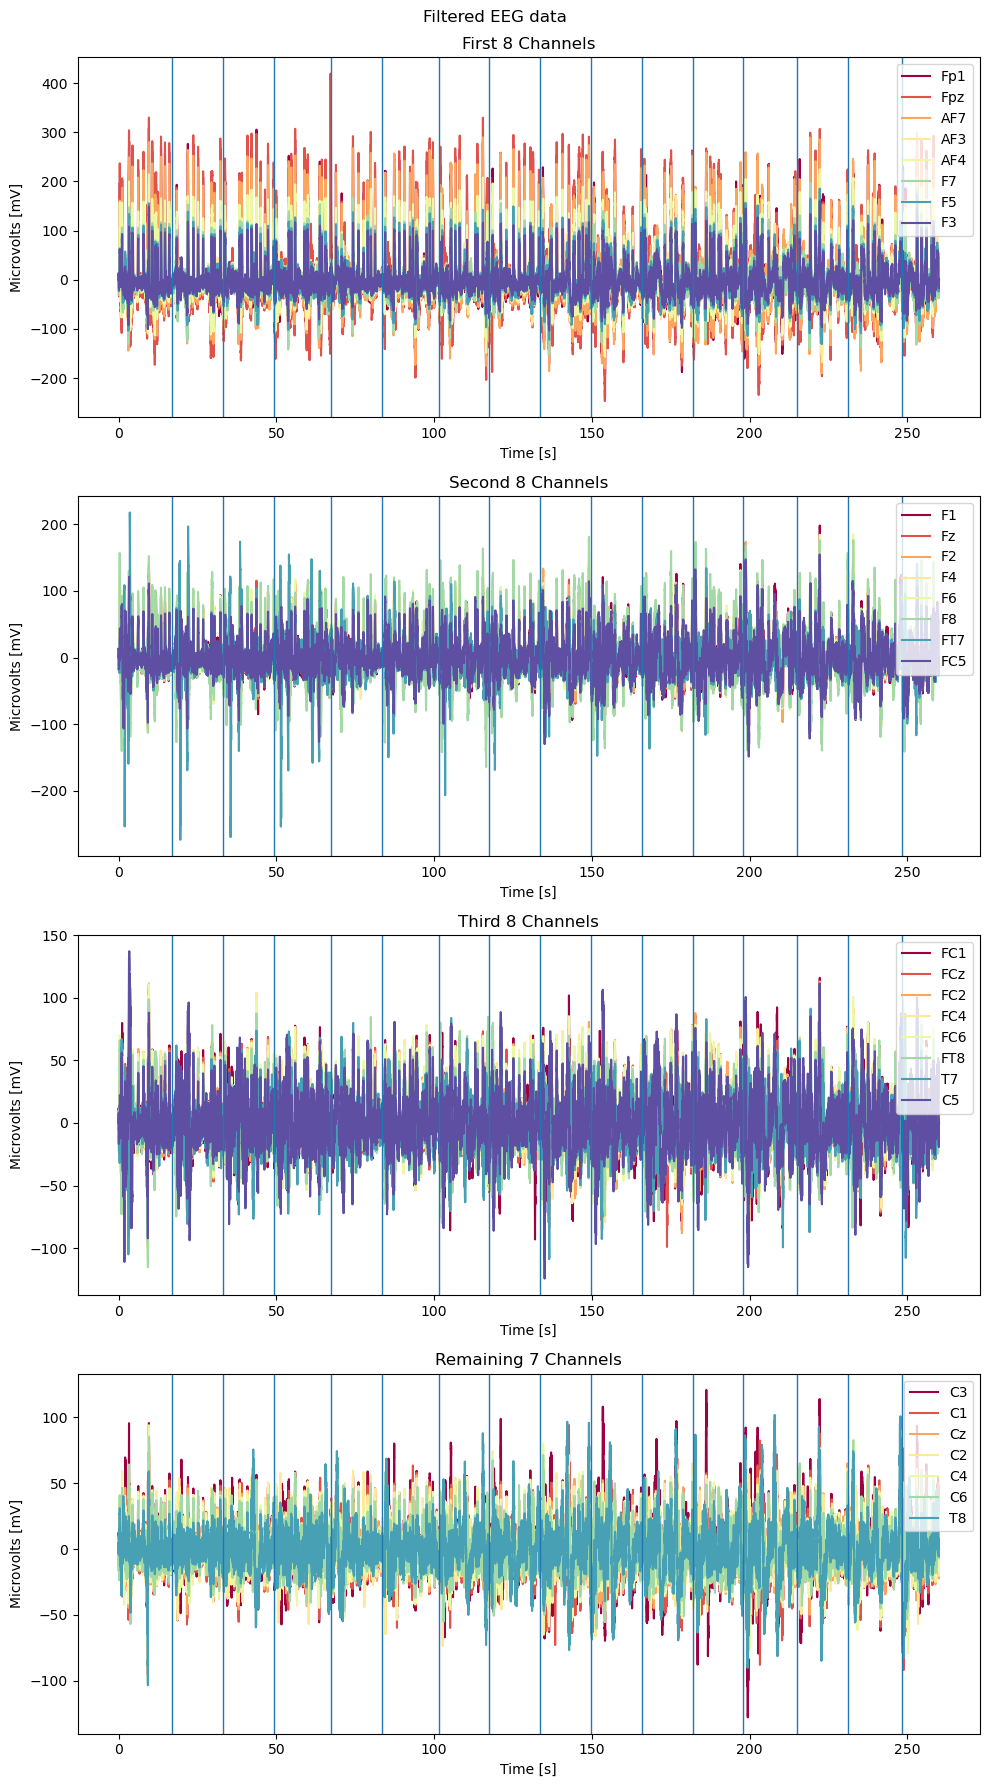

In [27]:
title = 'Filtered EEG data'
plotMNEArrSubplots(filtered_motor_eeg,1e6,title,filtered_motor_eeg.ch_names,show_trigger=True)

In [16]:
# Create ICA objects for eyes reation data by variance
motor_ica = mne.preprocessing.ICA(n_components=0.999, max_iter="auto", random_state=97)
motor_ica.fit(filtered_motor_eeg)

Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by explained variance: 27 components
Fitting ICA took 6.8s.


<ICA | raw data decomposition, method: fastica (fit in 77 iterations on 133121 samples), 27 ICA components (31 PCA components available), channel types: eeg, no sources marked for exclusion>

In [19]:
motor_ica.plot_sources(filtered_motor_eeg)

Creating RawArray with float64 data, n_channels=27, n_times=133121
    Range : 51200 ... 184320 =    100.000 ...   360.000 secs
Ready.
Using qt as 2D backend.


In [17]:
# For eye reaction2024.04.15_11.24.09
#motor_comp_to_exclude = [0,1,2,3,4,5,14]#,26,29,33,34,35,36,37,41,42,43,44]

# For neck left2024.05.14_12
#motor_comp_to_exclude = [0,3,4,7]#,8,9,10,12,13,16,18,19,21,22,23,25,26]

# For neck right2024.05.14_12
motor_comp_to_exclude = [0,2,4,23,6,8]#,10,11,13,14,15,21,23,24,26]

Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 6 ICA components
    Projecting back using 31 PCA components


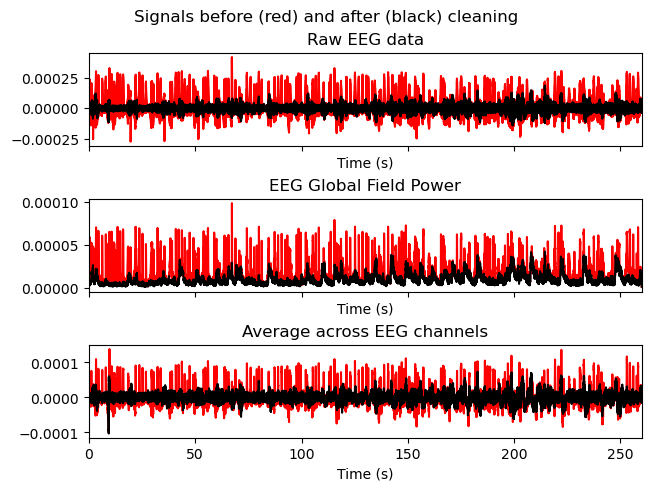

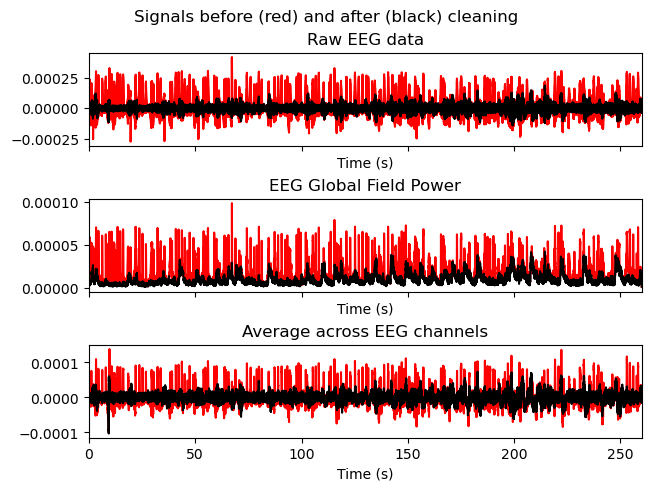

In [21]:
motor_ica.plot_overlay(filtered_motor_eeg, exclude=motor_comp_to_exclude,start=0, stop=133120)

In [18]:
# Set the components to exclude
motor_ica.exclude = motor_comp_to_exclude

In [19]:
# Actually apply the removal on the filtered data
motor_icaed_eeg = filtered_motor_eeg.copy()
motor_ica.apply(motor_icaed_eeg)

Applying ICA to Raw instance


    Transforming to ICA space (27 components)
    Zeroing out 6 ICA components
    Projecting back using 31 PCA components


<RawArray | 31 x 133121 (260.0 s), ~31.5 MB, data loaded>

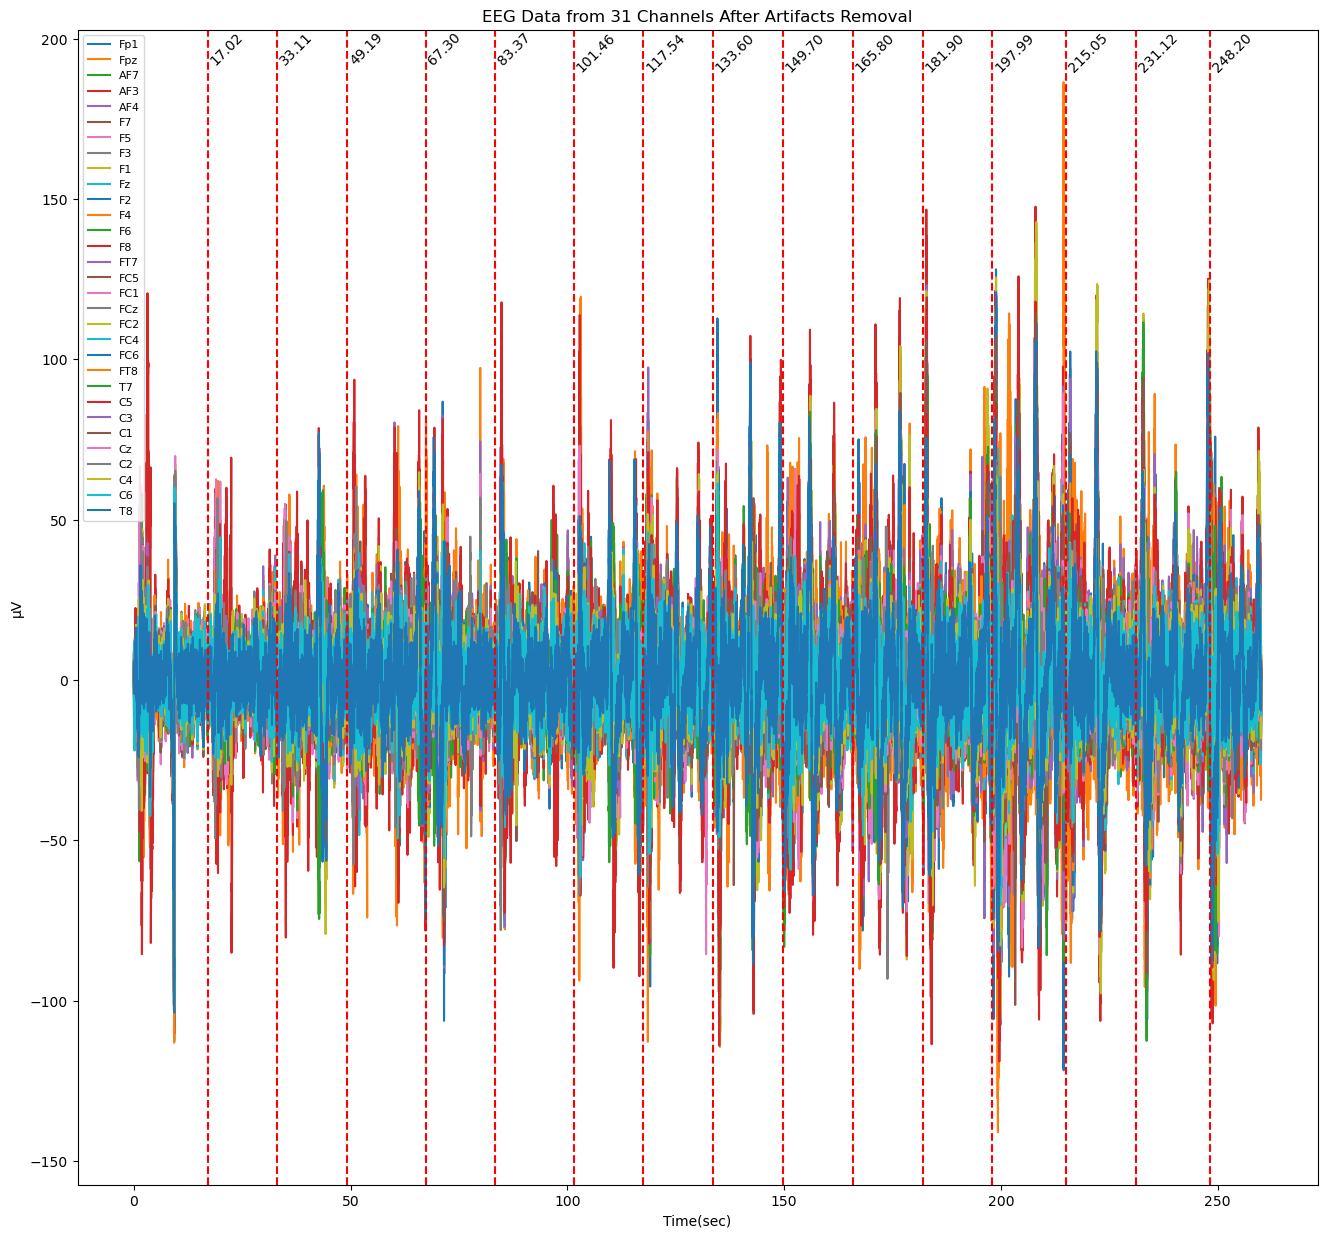

In [24]:
plotMNEData(mne_data=motor_icaed_eeg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='EEG Data from %d Channels After Artifacts Removal'%(len(motor_icaed_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='icaed_motor_eeg.png', show_trigger=True, show_plt=True)

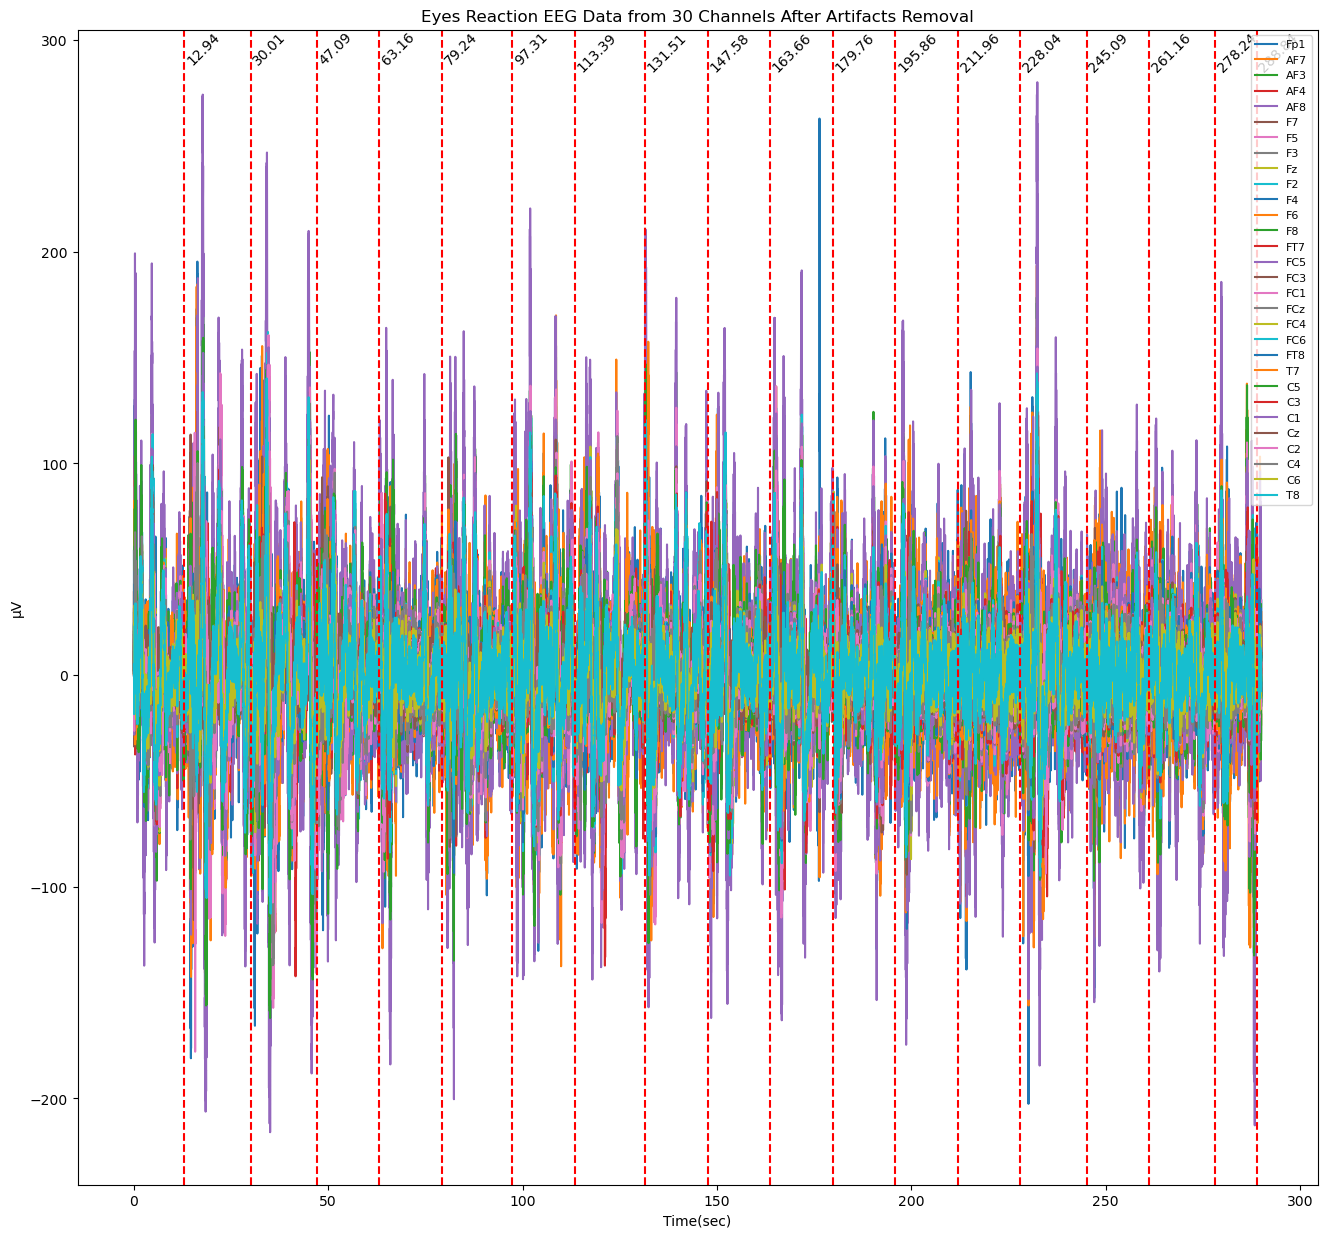

In [26]:
plotMNEData(mne_data=motor_icaed_eeg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Eyes Reaction EEG Data from %d Channels After Artifacts Removal'%(len(motor_icaed_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='icaed_motor_eeg.png', show_trigger=True, show_plt=True)

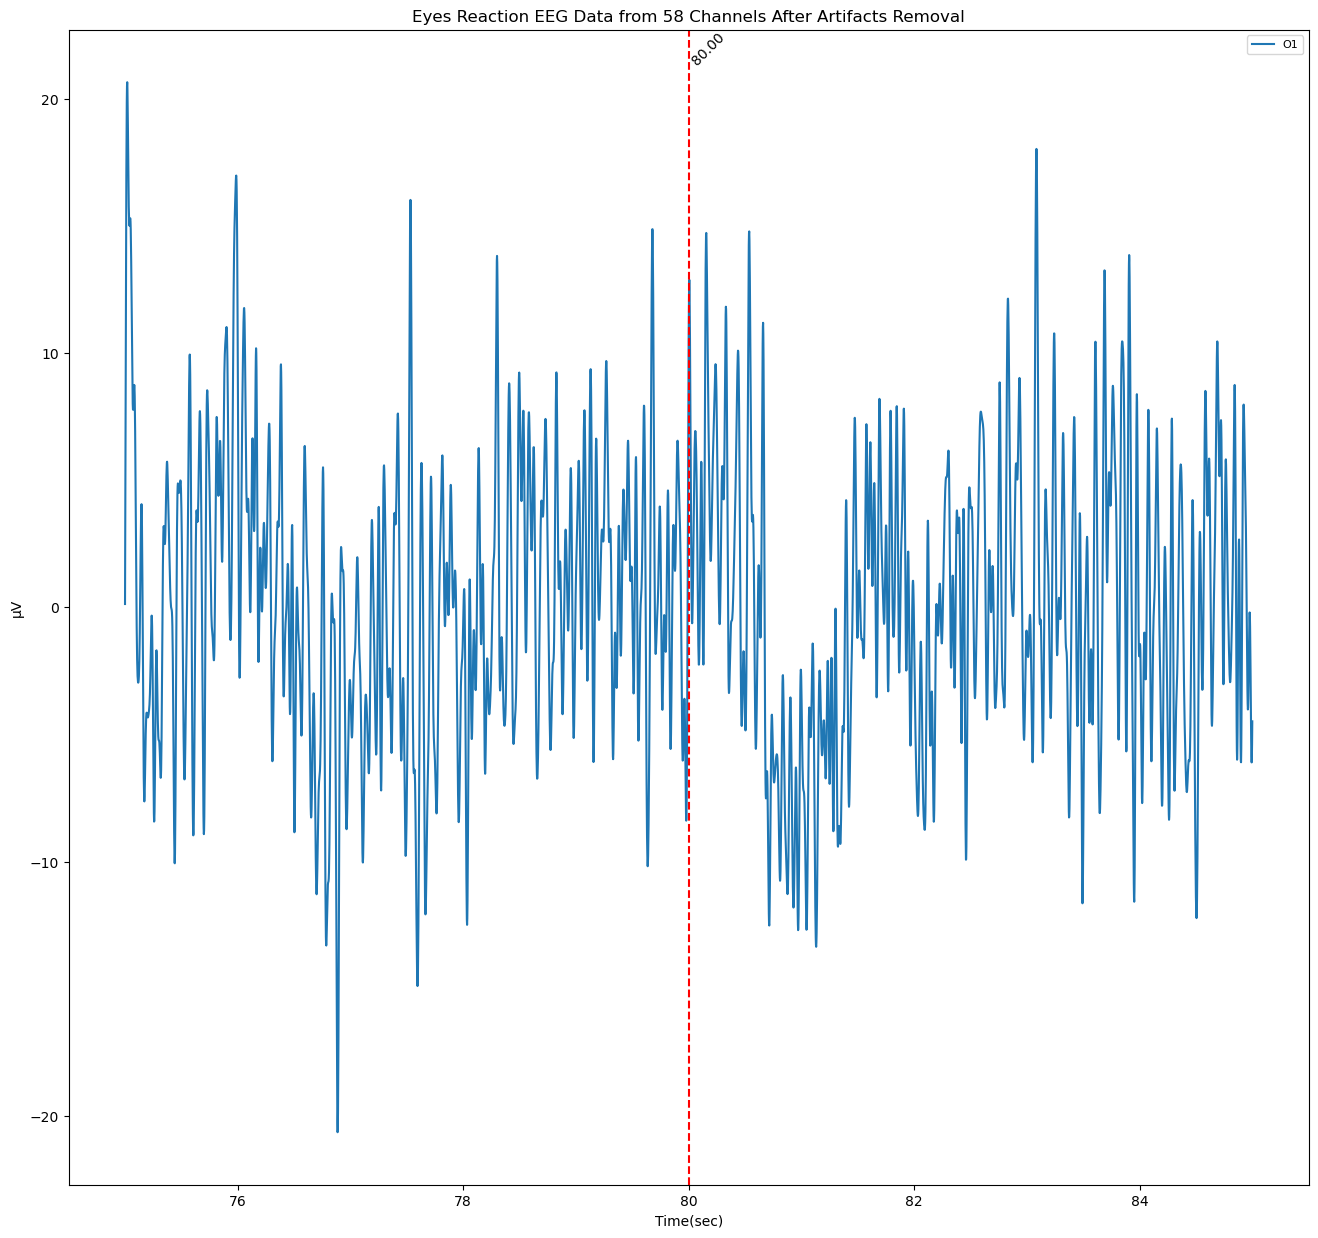

In [41]:
plotMNEData(mne_data=motor_icaed_eeg, domain='time', scaling=1e6, plt_x_range=(75,85),
            title='Eyes Reaction EEG Data from %d Channels After Artifacts Removal'%(len(motor_icaed_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            channels=['O1'], show_param_ch=True, show_trigger=True, show_plt=True)

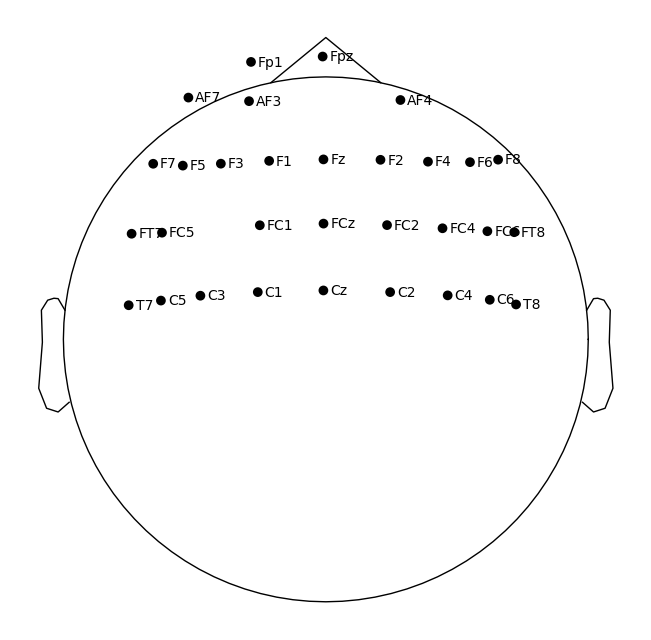

In [20]:
# Set up montage for Topomaps
easycap_montage = mne.channels.make_standard_montage('standard_1020')
# Rename eyes opened EEG channel names to match the names in the montage
# For eye reaction2024.04.15_11.24.09
#montage_rename_mapping = {'FPz':'Fpz','FP2':'Fp2'}
#motor_icaed_eeg.rename_channels(montage_rename_mapping)

motor_icaed_eeg.set_montage(easycap_montage)
fig = motor_icaed_eeg.plot_sensors(show_names=True)

In [21]:
def genTFRFromEEGAnnot(eeg_arr, epoch_tmin, epoch_tmax, baseline=None, baseline_mode="percent", 
                       freqs_of_interest=(1,31), avg_across_epochs=False):
    # generate events from annotations in eeg data
    events_from_annot, event_dict = mne.events_from_annotations(eeg_arr)
    print(event_dict)
    # generate epochs for the events
    epochs = mne.Epochs(motor_icaed_eeg,events_from_annot,event_id=event_dict,
                        tmin=epoch_tmin,tmax=epoch_tmax,baseline=None,preload=True)
    # compute time-frequency representation for the epoched data
    freqs_arr = np.arange(freqs_of_interest[0], freqs_of_interest[1])
    eeg_tfr = epochs.compute_tfr(method="multitaper",freqs=freqs_arr,n_cycles=freqs_arr,
                                 use_fft=True,return_itc=False,average=avg_across_epochs,decim=2)
    
    if baseline:
        eeg_tfr.crop(epoch_tmin, epoch_tmax).apply_baseline(baseline, mode=baseline_mode)
    
    return eeg_tfr

In [22]:
# For eye reaction2024.04.15_11.24.09
#motor_eeg_tfr = genTFRFromEEGAnnot(motor_icaed_eeg,-1,1.5,baseline=(-1,0), baseline_mode='mean')

#For neck left/right2024.05.14_12
motor_eeg_tfr = genTFRFromEEGAnnot(motor_icaed_eeg,-1,2,baseline=(-1,0), baseline_mode='mean')

Used Annotations descriptions: ['Neck_Right']
{'Neck_Right': 1}
Not setting metadata
15 matching events found


No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 1537 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Applying baseline correction (mode: mean)


In [23]:
#motor_eeg_tfr.to_data_frame().epoch.value_counts()

In [30]:
def computeAvgTFRPower(eeg_tfr, avg_over_ch='mean', condition:str=""):
    tfr_df = eeg_tfr.to_data_frame(time_format=None)
    # if condition is specified, and the specified condition exists in the EEG data
    # only take the rows in the dataframe that are with the specified condition value
    if condition and (condition in tfr_df['condition'].unique()):
        tfr_df = tfr_df[tfr_df['condition']==condition]

    # if average over mean, first compute mean over all channels
    if avg_over_ch == 'mean':
        tfr_df['mean'] = tfr_df.drop(columns=['time','freq','epoch','condition']).mean(axis=1)

    # Initialize numpy 2D array to contain average power values across all epochs(time windows around triggers)
    uniq_times = list(tfr_df['time'].unique())
    uniq_freqs = list(tfr_df['freq'].unique())
    # note here we need to reverse the list of unique frequency values so that later the heatmap
    # can be plotted with low to high frequency from bottom to top.
    uniq_freqs.reverse()
    #print(uniq_freqs)
    avg_pw_arr = np.zeros((len(uniq_freqs),len(uniq_times)))

    # Compute average power for each unique (time,freq) pair, each pair should have 1 row for each epoch
    # hence the computed average will be the average power across all epochs
    uniq_time_freq = tfr_df[['time','freq']].value_counts().index
    for t,f in uniq_time_freq:
        avg_pw = tfr_df[(tfr_df['time'] == t) & (tfr_df['freq'] == f)][avg_over_ch].mean()
        avg_pw_arr[uniq_freqs.index(f),uniq_times.index(t)] = avg_pw

    return avg_pw_arr

In [31]:
def pltAvgTFRPowerHeatmap(eeg_tfr, plt_for_ch:str, plt_extents:list, plt_title:str="",
                          cnorm_vmin=None, cnorm_vmax=None, condition:str=""):
    # Compute average powers across all epochs
    tfr_avg_pw = computeAvgTFRPower(eeg_tfr,plt_for_ch,condition)
    # Note that the numpy array with average power that is computed above is ordered from high frequency to low frequency 
    # (e.g., 30Hz to 1Hz from the first row tfr_avg_pw[0] to the last row tfr_avg_pw[-1])
    tfr_avg_pw_trunc = tfr_avg_pw[tfr_avg_pw.shape[0]-plt_extents[3]:tfr_avg_pw.shape[0]-plt_extents[2]+1]
    print(tfr_avg_pw_trunc.shape)
    # initialize color normalization 
    if cnorm_vmin and cnorm_vmax:
        cnorm = matplotlib.colors.TwoSlopeNorm(vmin=cnorm_vmin, vcenter=0, vmax=cnorm_vmax)
        plt.imshow(tfr_avg_pw, extent=plt_extents, aspect='auto',norm=cnorm,cmap='RdBu_r') 
    else:
        cnorm_vmin = np.min(tfr_avg_pw_trunc)
        cnorm_vmax = np.max(tfr_avg_pw_trunc)
        cnorm_vcenter = (cnorm_vmin+cnorm_vmax)/2
        print(cnorm_vmin, cnorm_vmax, cnorm_vcenter)
        cnorm = matplotlib.colors.TwoSlopeNorm(vmin=cnorm_vmin, vcenter=cnorm_vcenter, vmax=cnorm_vmax)
        plt.imshow(tfr_avg_pw_trunc, extent=plt_extents, norm=cnorm, aspect='auto',cmap='RdBu_r', ) 
        
    plt.colorbar() 
    plt.title(plt_title) 
    plt.show()

(27, 769)
-6.698257407057231e-10 2.87518443806612e-09 1.1026793486801983e-09


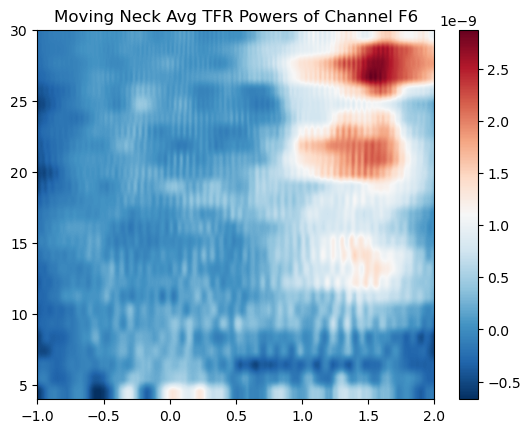

In [32]:
# For eye reaction2024.04.15_11.24.09
#pltAvgTFRPowerHeatmap(motor_eeg_tfr, plt_for_ch='Fpz', plt_extents=[-1,1.5,4,30], 
#                      plt_title="Open Eyes Avg TFR Powers of Channel FPz", #cnorm_vmin=-2, cnorm_vmax=2, 
#                      condition="Eye_Open")

# For neck left/right2024.05.14_12
pltAvgTFRPowerHeatmap(motor_eeg_tfr, plt_for_ch='F6', plt_extents=[-1,2,4,30], 
                      plt_title="Moving Neck Avg TFR Powers of Channel F6")

In [194]:
#motor_eeg_avg_tfr_df = motor_eeg_tfr['Eye_Open'].average(method='mean', dim='epochs').to_data_frame()
#motor_eeg_avg_tfr_df[(motor_eeg_avg_tfr_df['freq'] >= 4) & (motor_eeg_avg_tfr_df['freq'] <= 30)]['FPz'].max()

In [28]:
def pltAvgTFRPowerHeatmap(eeg_tfr, plot_for_ch, plt_title:str="",fmin=0, fmax=np.inf, cnorm_vmin=None, 
                          cnorm_vmax=None, condition:str=""):
    # Compute average powers across all epochs (of specified condition)
    if condition and (condition in eeg_tfr.event_id):
        avg_tfr = eeg_tfr[condition].average(method='mean', dim='epochs')
    else:
        avg_tfr = eeg_tfr.average(method='mean', dim='epochs')

    if cnorm_vmin and cnorm_vmax:
        # initialize color normalization
        cnorm_center = (cnorm_vmin+cnorm_vmax)/2
        cnorm = matplotlib.colors.TwoSlopeNorm(vmin=cnorm_vmin, vcenter=0, vmax=cnorm_vmax)
        avg_tfr.plot(plot_for_ch,fmin=fmin,fmax=fmax,cnorm=cnorm,title=plt_title)
    else:
        # initialize color normalization
        avg_tfr_df = avg_tfr.to_data_frame()
        cnorm_max = avg_tfr_df[(avg_tfr_df['freq'] >= fmin) & (avg_tfr_df['freq'] <= fmax)][plot_for_ch].max()
        cnorm_min = avg_tfr_df[(avg_tfr_df['freq'] >= fmin) & (avg_tfr_df['freq'] <= fmax)][plot_for_ch].min()
        cnorm_center = (cnorm_max+cnorm_min)/2
        cnorm = matplotlib.colors.TwoSlopeNorm(vmin=cnorm_vmin, vcenter=cnorm_center, vmax=cnorm_vmax)
        avg_tfr.plot(plot_for_ch,fmin=fmin,fmax=fmax,cnorm=cnorm,title=plt_title)

No baseline correction applied


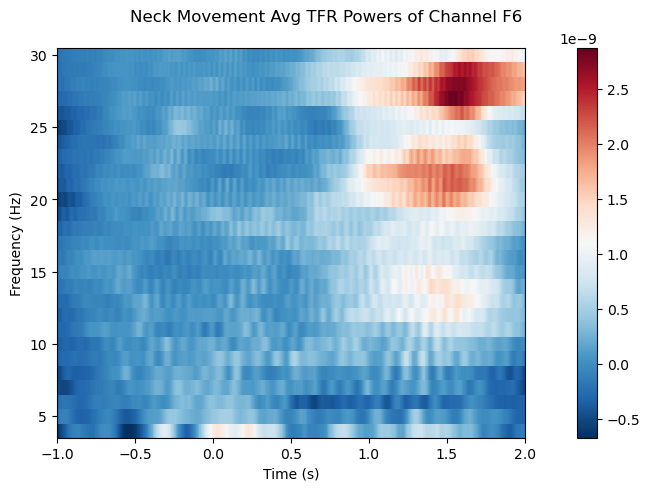

In [29]:
# For eye reaction2024.04.15_11.24.09
#pltAvgTFRPowerHeatmap(motor_eeg_tfr, 'Fpz', plt_title="Open Eyes Avg TFR Powers of Channel FPz",
#                      fmin=4, fmax=30, condition="Eye_Open")

# For neck left/right2024.05.14_12
pltAvgTFRPowerHeatmap(motor_eeg_tfr, 'F6', plt_title="Neck Movement Avg TFR Powers of Channel F6",
                      fmin=4, fmax=30)

No baseline correction applied


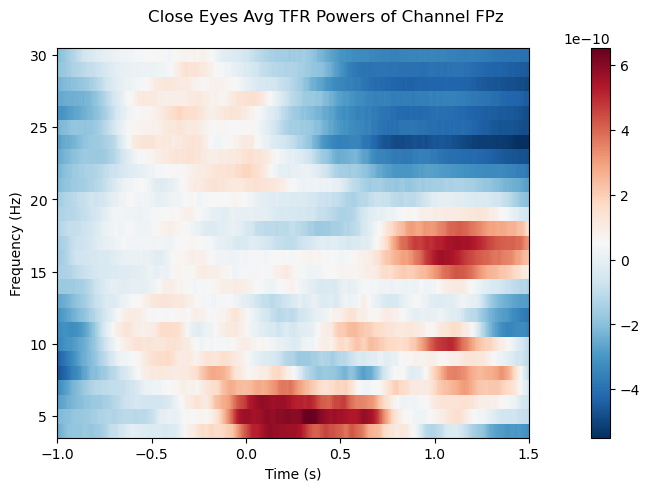

In [211]:
#pltAvgTFRPowerHeatmap(motor_eeg_tfr, 'Fpz', plt_title="Close Eyes Avg TFR Powers of Channel FPz",
#                      fmin=4, fmax=30, condition="Eye_Close")

No baseline correction applied


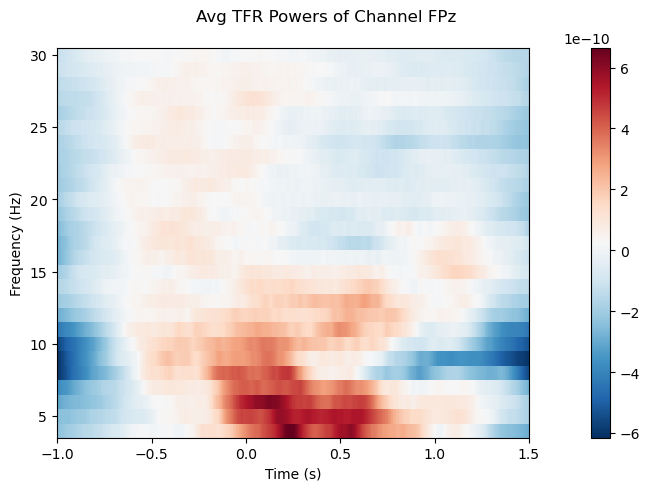

In [212]:
#pltAvgTFRPowerHeatmap(motor_eeg_tfr, 'Fpz', plt_title="Avg TFR Powers of Channel FPz",
#                      fmin=4, fmax=30)

In [66]:
# Average the TFR power across all epochs when generating the TFR from annotations
# the result values would be different from when averaging the powers after generating the TFR (what has been done above)
#avg_motor_eeg_tfr = genTFRFromEEGAnnot(motor_icaed_eeg,-1,1.5,baseline=(-1,0),avg_across_epochs=True)

In [67]:
# Note here the heatmaps below would be different from the heatmaps above
#avg_motor_eeg_tfr.plot(["FPz"],cnorm=cnorm)

In [24]:
FREQ_BOUNDS = {"_": 1, "delta": 4, "theta": 8, "alpha": 12, "beta": 30}

def plotERDSFromTFR(eeg_tfr, channels=[], show_param_channels=False, avg_across_epochs=False, 
                    condition:str="", freq_bands_to_exclude=[]):
    if avg_across_epochs:
        if condition and (condition in eeg_tfr.event_id):
            df = eeg_tfr[condition].average(method='mean', dim='epochs').to_data_frame(time_format=None, long_format=True)
        else:
            df = eeg_tfr.average(method='mean', dim='epochs').to_data_frame(time_format=None, long_format=True)
    else:
        if condition and (condition in eeg_tfr.event_id):
            df = eeg_tfr[condition].to_data_frame(time_format=None, long_format=True)
        else:
            df = eeg_tfr.to_data_frame(time_format=None, long_format=True)

    # Map to frequency bands:
    df["band"] = pd.cut(
        df["freq"], list(FREQ_BOUNDS.values()), labels=list(FREQ_BOUNDS)[1:]
    )

    # Filter to retain only relevant frequency bands and exclude channels that are not to be shown:
    freq_bands_of_interest = [band for band in ["delta", "theta", "alpha", "beta"] if band not in freq_bands_to_exclude]
    
    df = df[df['band'].isin(freq_bands_of_interest)]
    
    if show_param_channels:
        df = df[df['channel'].isin(channels)]
    else:
        df = df[~df['channel'].isin(channels)]
        
    df["band"] = df["band"].cat.remove_unused_categories()
    df["channel"] = df["channel"].cat.remove_unused_categories()


    g = sns.FacetGrid(df, row="band", margin_titles=True, aspect=2.5)
    g.map(sns.lineplot, "time", "value", "channel", n_boot=10)
    axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
    g.map(plt.axhline, y=0, **axline_kw)
    g.map(plt.axvline, x=0, **axline_kw)
    g.set_axis_labels("Time (s)", "ERDS")
    g.set_titles(row_template="{row_name}")
    g.add_legend()


Converting "channel" to "category"...
Converting "ch_type" to "category"...


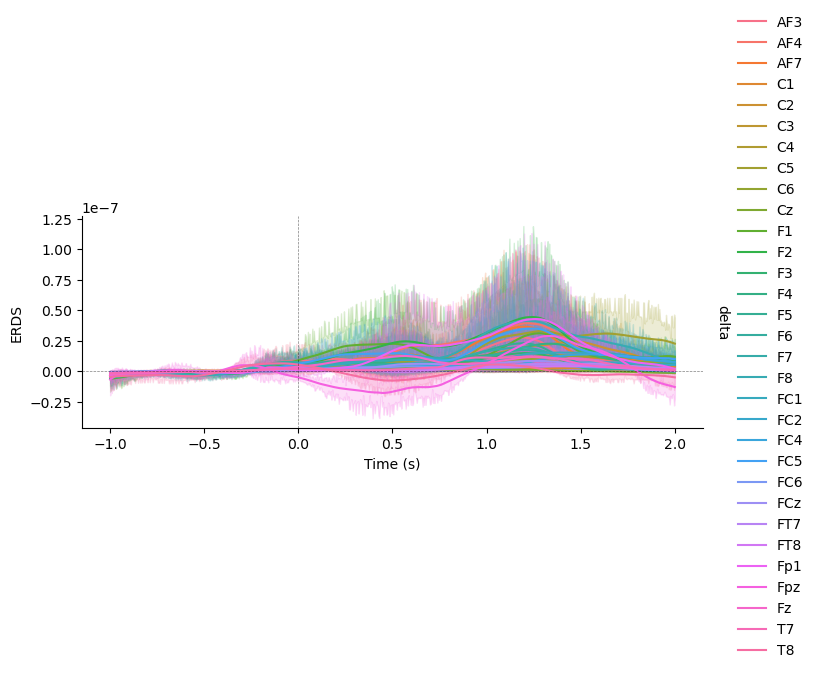

In [34]:
# For neck left/right2024.05.14_12
plotERDSFromTFR(motor_eeg_tfr,channels=[], show_param_channels=False, avg_across_epochs=True, 
                freq_bands_to_exclude=["theta", "alpha", "beta"])

Converting "channel" to "category"...
Converting "ch_type" to "category"...


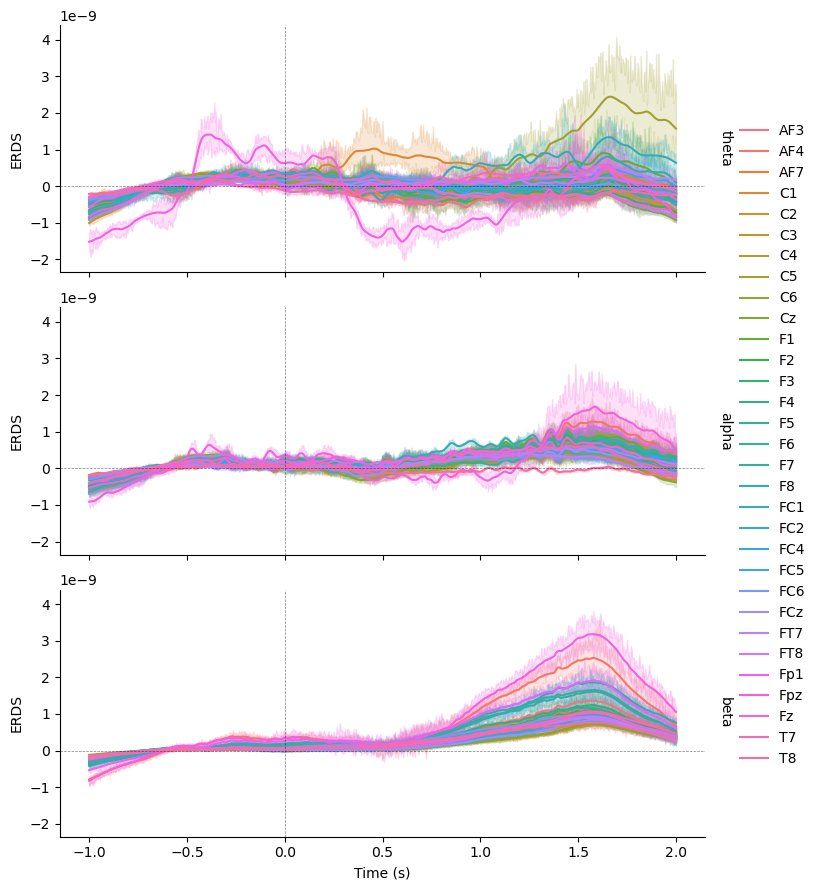

In [35]:
# For eye reaction2024.04.15_11.24.09
#plotERDSFromTFR(motor_eeg_tfr,channels=['O1'], show_param_channels=False, avg_across_epochs=True, condition='Eye_Open')

# For neck left/right2024.05.14_12
plotERDSFromTFR(motor_eeg_tfr,channels=[], show_param_channels=False, avg_across_epochs=True, freq_bands_to_exclude=['delta'])

Converting "channel" to "category"...
Converting "ch_type" to "category"...


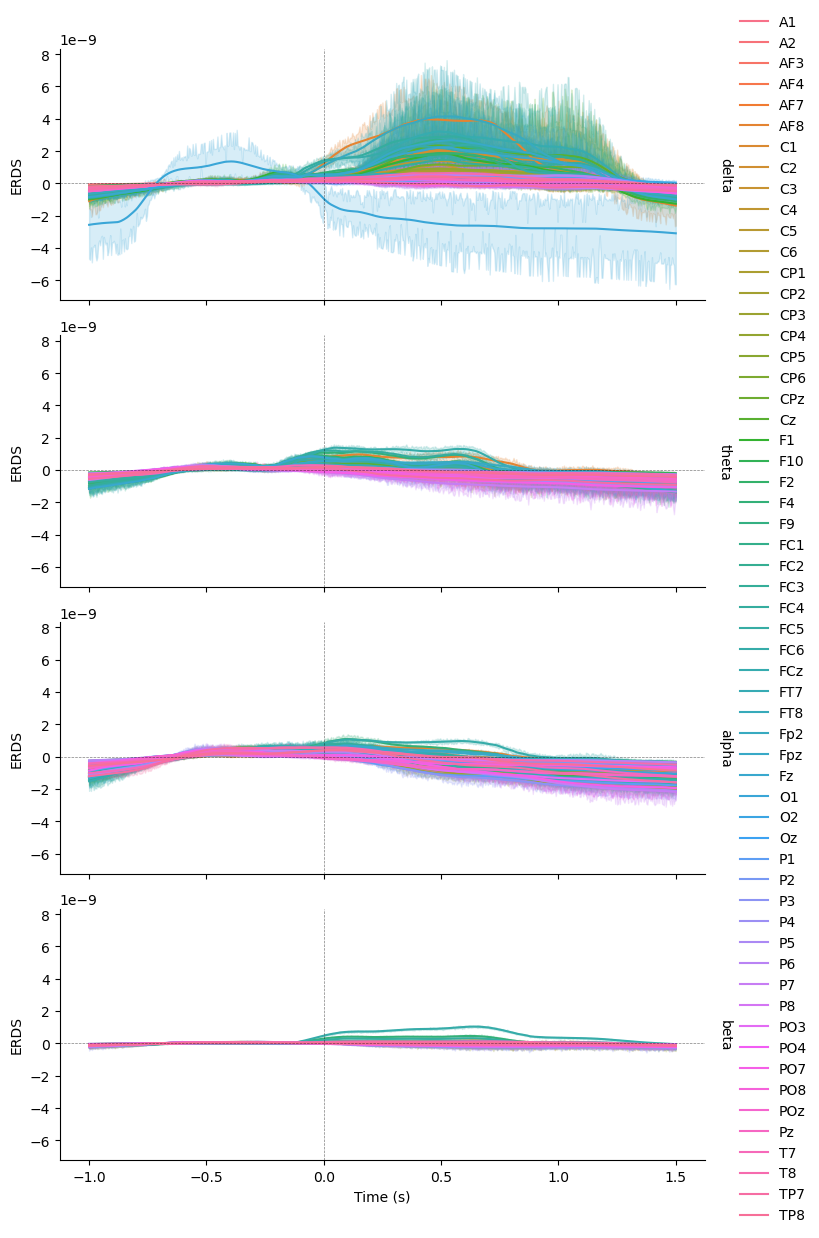

In [30]:
# For eye reaction2024.04.15_11.24.09
plotERDSFromTFR(motor_eeg_tfr,channels=[], show_param_channels=False, avg_across_epochs=True, condition='Eye_Open')

Converting "channel" to "category"...
Converting "ch_type" to "category"...


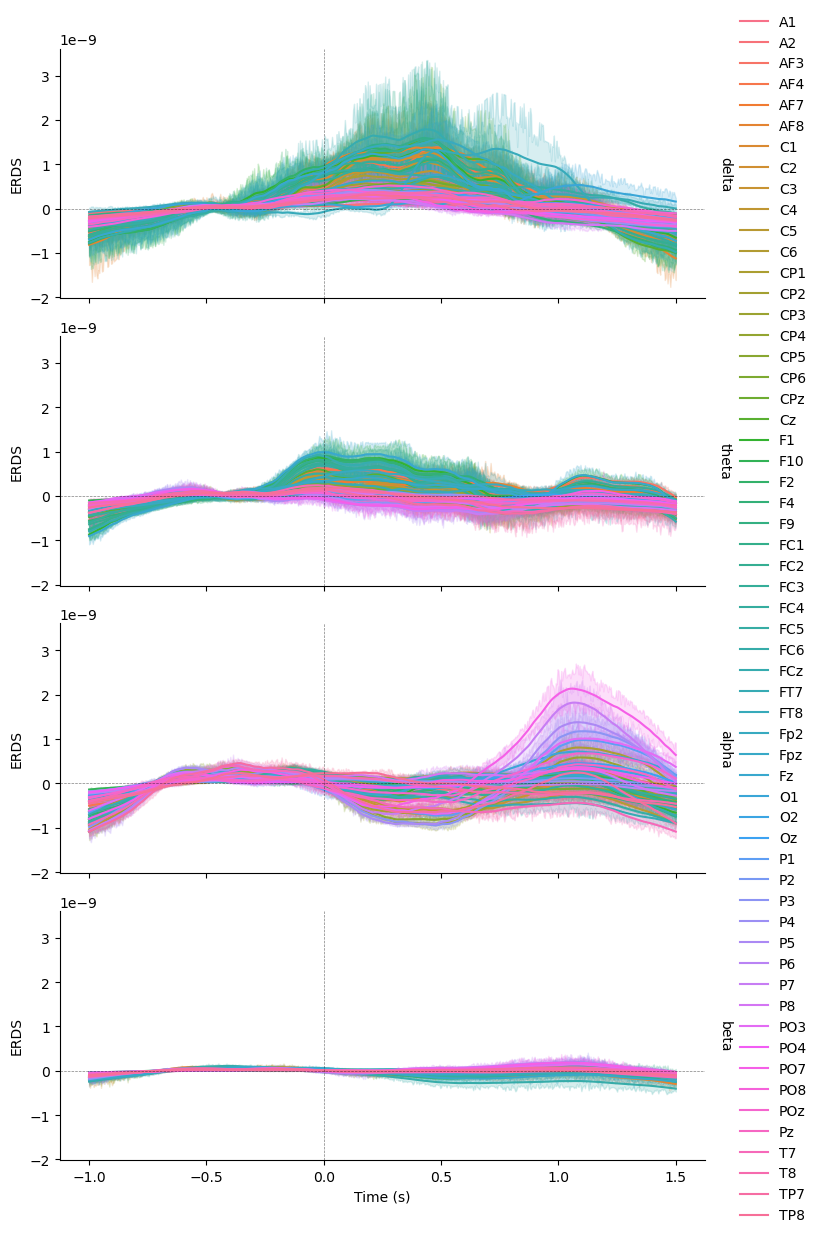

In [25]:
# For eye reaction2024.04.15_11.24.09
plotERDSFromTFR(motor_eeg_tfr,channels=[], show_param_channels=False, avg_across_epochs=True, condition='Eye_Close')

Converting "channel" to "category"...
Converting "ch_type" to "category"...


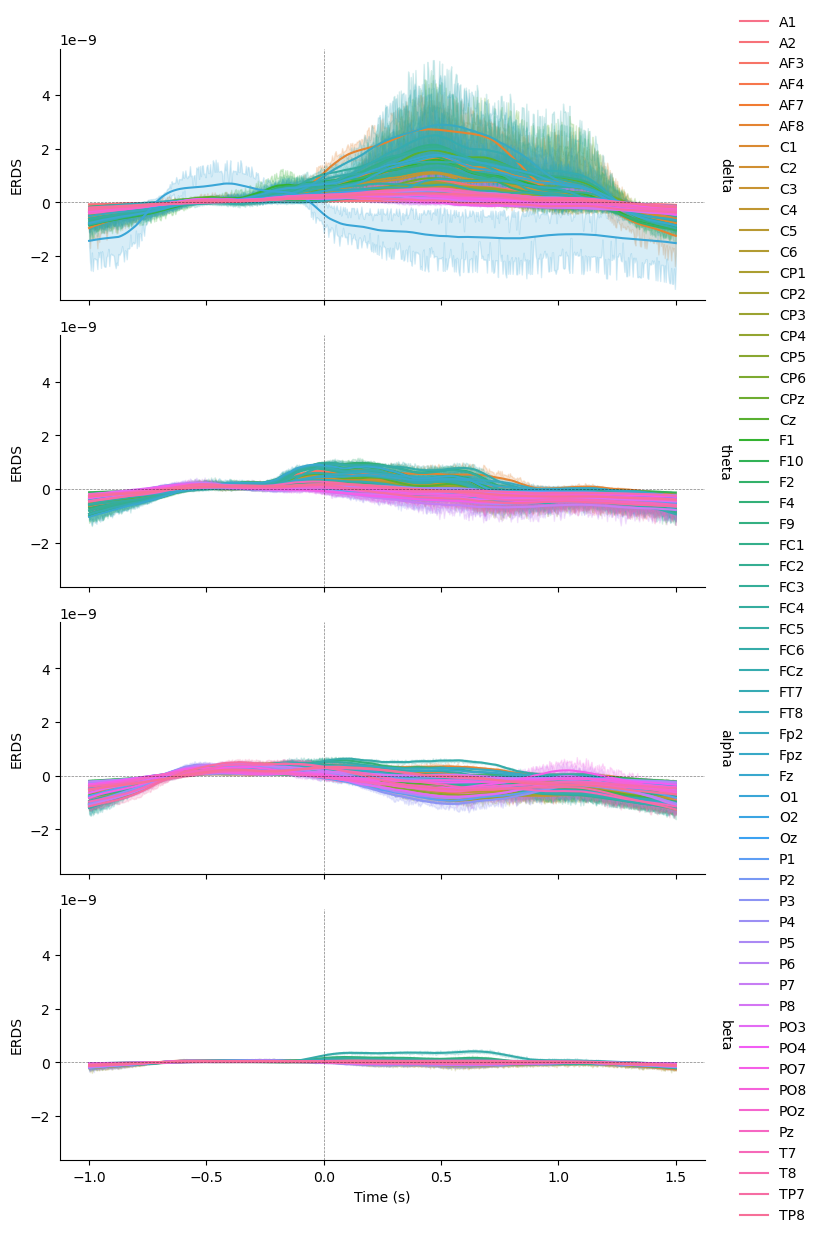

In [31]:
plotERDSFromTFR(motor_eeg_tfr,channels=[], show_param_channels=False, avg_across_epochs=True)

In [79]:
#plotERDSFromTFR(avg_motor_eeg_tfr,channels=[], show_param_channels=False, avg_across_epochs=False)

In [25]:
FREQ_BANDS_DICT = dict(delta=dict(fmin=0.5, fmax=4), theta=dict(fmin=4, fmax=8),
                       alpha=dict(fmin=8, fmax=12), beta=dict(fmin=12, fmax=30))

def plotTFRAvgPowerTopomap(eeg_tfr, epoch_tmin:float, epoch_tmax:float, 
                           condition:str='', ch_to_exclude:list=[]):
    
    fig,axes = plt.subplots(1, 4, figsize=(12, 4), layout="constrained")
    # Topomap function call keywords
    topomap_kw = dict(tmin=epoch_tmin, tmax=epoch_tmax, show=False)
    for ax, (title, fmin_fmax) in zip(axes, FREQ_BANDS_DICT.items()):
        # Average the TFR power data over all epochs/epoch with specified condition, 
        # and drop the channel(s) to be excluded
        if condition:
            avg_tfr_wo_exclude_ch = eeg_tfr[condition].average(method='mean', dim='epochs').copy().drop_channels(ch_to_exclude)
        else:
            avg_tfr_wo_exclude_ch = eeg_tfr.average(method='mean', dim='epochs').copy().drop_channels(ch_to_exclude)
        avg_tfr_wo_exclude_ch.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
        ax.set_title(title)

No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


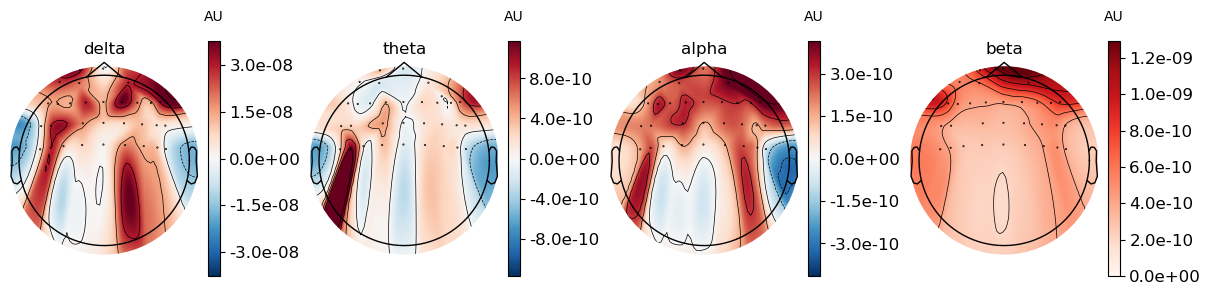

In [26]:
# For eye reaction2024.04.15_11.24.09
#plotTFRAvgPowerTopomap(motor_eeg_tfr, 0, 1.5, 'Eye_Open', [])

# For neck left/right2024.05.14_12
plotTFRAvgPowerTopomap(motor_eeg_tfr, 0, 2, [])

No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


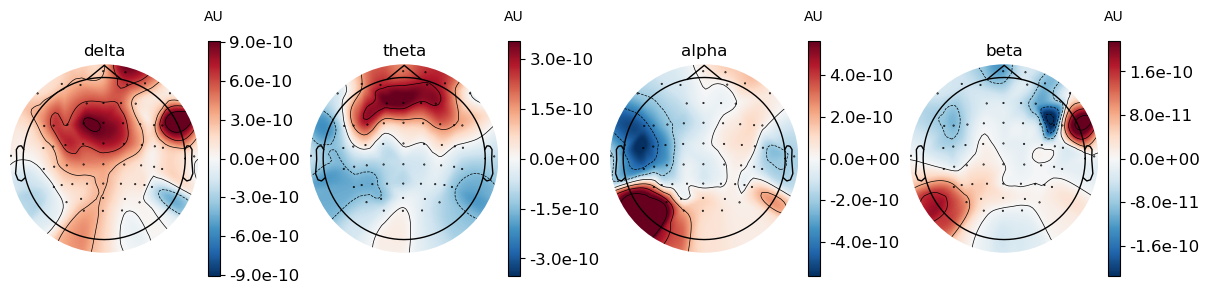

In [34]:
# For eye reaction2024.04.15_11.24.09
plotTFRAvgPowerTopomap(motor_eeg_tfr, 0, 1.5, 'Eye_Close', [])

In [27]:
def computeEEGEMGTrigCorr(eeg_arr, emg_arr, eeg_bp_filter_range:tuple[float]=None, eeg_notch_filter_freq:float=0, 
                          eeg_moving_avg_win:float=0, emg_moving_avg_win:float=0, trig_time_win:tuple=(-1,2), 
                          corr_time_win:tuple=(0.5,1.5)):
    # Preprocess the EEG data with band-pass and/or notch filter if eeg_bp_filter_range and/or notch_filter_freq is specified 
    if eeg_bp_filter_range:
        eeg_arr = eeg_arr.copy().filter(eeg_bp_filter_range[0],eeg_bp_filter_range[1])
    if eeg_notch_filter_freq:
        eeg_arr = eeg_arr.copy().notch_filter(eeg_notch_filter_freq, method='fir')

    # Check if the sampling frequencies of the EEG and EMG data are equal to each other
    # if not, raise error
    eeg_sfreq = eeg_arr.info['sfreq']
    emg_sfreq = emg_arr.info['sfreq']
    if eeg_sfreq != emg_sfreq:
        raise ValueError("The sampling frequencies of input EEG and EMG data are not equal to each other.")
    
    # Get the EMG data into numpy array, compute its power (i.e. square the data), 
    # then compute moving average if emg_moving_avg_win is specified
    emg_arr = emg_arr.get_data().squeeze()**2
    if emg_moving_avg_win:
        # Multiply the moving average (time) window by sampling frequency to 
        # get the actual window length in the numpy array (i.e. the number of array entries)
        win_by_arr_len = round(emg_moving_avg_win*emg_sfreq)
        print(len(np.ones(win_by_arr_len)/win_by_arr_len))
        print(len(emg_arr))
        emg_arr = np.convolve(emg_arr, np.ones(win_by_arr_len)/win_by_arr_len, mode='valid')

    # Dictionary to record the correlation values between each EEG channel and the EMG channel
    corr_dict = {}
    # Get the timestamps of the triggers(annotations) in the EEG
    trig_times = [ annot['onset']-FIRST_SECS_TO_REMOVE for annot in eeg_arr.annotations]
    # Loop through each EEG channel
    for ch in eeg_arr.ch_names:
        # Get the the EEG data of current channel into numpy array, compute its power 
        # then compute moving average if eeg_moving_avg_win is specified
        curr_ch_eeg_arr = eeg_arr.get_data(ch).squeeze()**2
        if eeg_moving_avg_win:
            win_by_arr_len = round(eeg_moving_avg_win*eeg_sfreq)
            curr_ch_eeg_arr = np.convolve(curr_ch_eeg_arr, np.ones(win_by_arr_len)/win_by_arr_len, mode='valid')
        trig_corr = []
        for t in trig_times:
            trig_idx = round(t*eeg_sfreq)
            corr_idx_win = (trig_idx+round(corr_time_win[0]*eeg_sfreq), trig_idx+round(corr_time_win[1]*eeg_sfreq))
            #print(corr_idx_win)
            # check if the index window for correlation calculation will be out of range of the EEG and EMG data arrays
            if ((corr_idx_win[1]>curr_ch_eeg_arr.shape[0]) 
                or (corr_idx_win[1]>emg_arr.shape[0])):
                break
            
            trig_corr.append(np.corrcoef(curr_ch_eeg_arr[corr_idx_win[0]:corr_idx_win[1]],
                                         emg_arr[corr_idx_win[0]:corr_idx_win[1]])[0][1])
        
        # Record the average correlation over all triggers
        corr_dict[ch] = sum(trig_corr)/len(trig_corr)
    
    return corr_dict

            

In [39]:
motor_eeg_emg_corr = computeEEGEMGTrigCorr(motor_eeg_wo_bad_ch, filtered_motor_emg, eeg_bp_filter_range=(8,12),
                                           eeg_notch_filter_freq=60, eeg_moving_avg_win=1, emg_moving_avg_win=0.03)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 845 samples (1.650 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


15
133121


In [40]:
motor_eeg_emg_corr

{'Fp1': -0.24188344455392935,
 'Fpz': -0.26406761923742517,
 'AF7': -0.20880078531306384,
 'AF3': -0.11946669880890406,
 'AF4': -0.11592893651551564,
 'F7': -0.026442519435529523,
 'F5': -0.1100085165833498,
 'F3': -0.03595194525891166,
 'F1': -0.047191345282411534,
 'Fz': -0.0606473698550295,
 'F2': -0.033307575142660265,
 'F4': -0.08816834186263602,
 'F6': -0.15797088343005453,
 'F8': -0.12636711797086925,
 'FT7': 0.39695289275540835,
 'FC5': 0.16993729783355704,
 'FC1': -0.022600360157394583,
 'FCz': -0.004315762705684559,
 'FC2': 0.007638007142253133,
 'FC4': -0.05203726422031856,
 'FC6': -0.1433676445953999,
 'FT8': -0.11499262500755769,
 'T7': -0.1345682530453021,
 'C5': 0.16026607516613287,
 'C3': 0.08097675161764009,
 'C1': -0.13659102800011316,
 'Cz': -0.029909386279930346,
 'C2': -0.037736525352429266,
 'C4': -0.1616688277799718,
 'C6': -0.05427161450425966,
 'T8': -0.03855354945791611}

In [28]:
icaed_motor_eeg_emg_corr = computeEEGEMGTrigCorr(motor_icaed_eeg, filtered_motor_emg, eeg_bp_filter_range=(8,12),
                                                 eeg_moving_avg_win=1, 
                                                 emg_moving_avg_win=0.03)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 845 samples (1.650 s)

15
133121


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [29]:
icaed_motor_eeg_emg_corr

{'Fp1': 0.12527635154817499,
 'Fpz': 0.2839370942909439,
 'AF7': 0.09780040340240613,
 'AF3': 0.19898065602567458,
 'AF4': 0.19594243507645528,
 'F7': 0.10375402206631902,
 'F5': 0.14833030960934218,
 'F3': 0.1669744495070602,
 'F1': 0.13937711345192808,
 'Fz': 0.16778724966485634,
 'F2': 0.15413297720898617,
 'F4': 0.19044789326014194,
 'F6': 0.14132662105634217,
 'F8': 0.039656613735349365,
 'FT7': 0.09564973757070963,
 'FC5': 0.18344754552784254,
 'FC1': 0.11197138209506727,
 'FCz': 0.13253593460522275,
 'FC2': 0.14942685900765262,
 'FC4': 0.017468536594143484,
 'FC6': 0.017961127319552194,
 'FT8': -0.061108705376200764,
 'T7': -0.07486499339262827,
 'C5': 0.20563611408461735,
 'C3': 0.08303658117829886,
 'C1': -0.021368987400424182,
 'Cz': 0.0715221911378248,
 'C2': 0.010169545130599651,
 'C4': -0.08036310192097613,
 'C6': 0.024204701474015957,
 'T8': -0.02111893288572547}

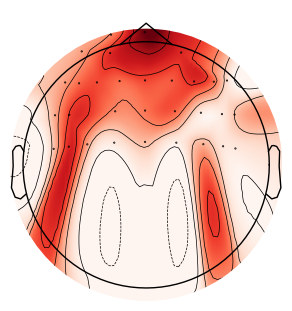

(<matplotlib.image.AxesImage at 0x1b7e56cd070>,
 <matplotlib.contour.QuadContourSet at 0x1b7e56cd490>)

In [47]:
mne.viz.plot_topomap(np.absolute(np.array(list(icaed_motor_eeg_emg_corr.values()))),pos = motor_icaed_eeg.info, ch_type='eeg',size=3)

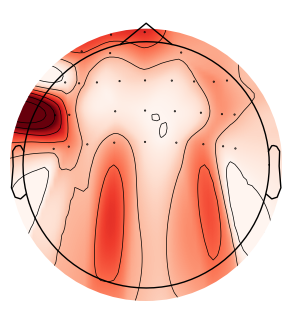

(<matplotlib.image.AxesImage at 0x1b7e57ba060>,
 <matplotlib.contour.QuadContourSet at 0x1b7e56380b0>)

In [43]:
mne.viz.plot_topomap(np.absolute(np.array(list(motor_eeg_emg_corr.values()))),pos = motor_icaed_eeg.info, ch_type='eeg',size=3)

In [62]:
[ annot['onset']-FIRST_SECS_TO_REMOVE for annot in raw_motor_data.annotations]

[12.943359000000001,
 30.009766,
 47.09375,
 63.158203000000015,
 79.242188,
 97.308594,
 113.39257800000001,
 131.509766,
 147.576172,
 163.658203,
 179.757812,
 195.85742200000004,
 211.958984,
 228.041016,
 245.09179700000004,
 261.158203,
 278.240234,
 288.841797]

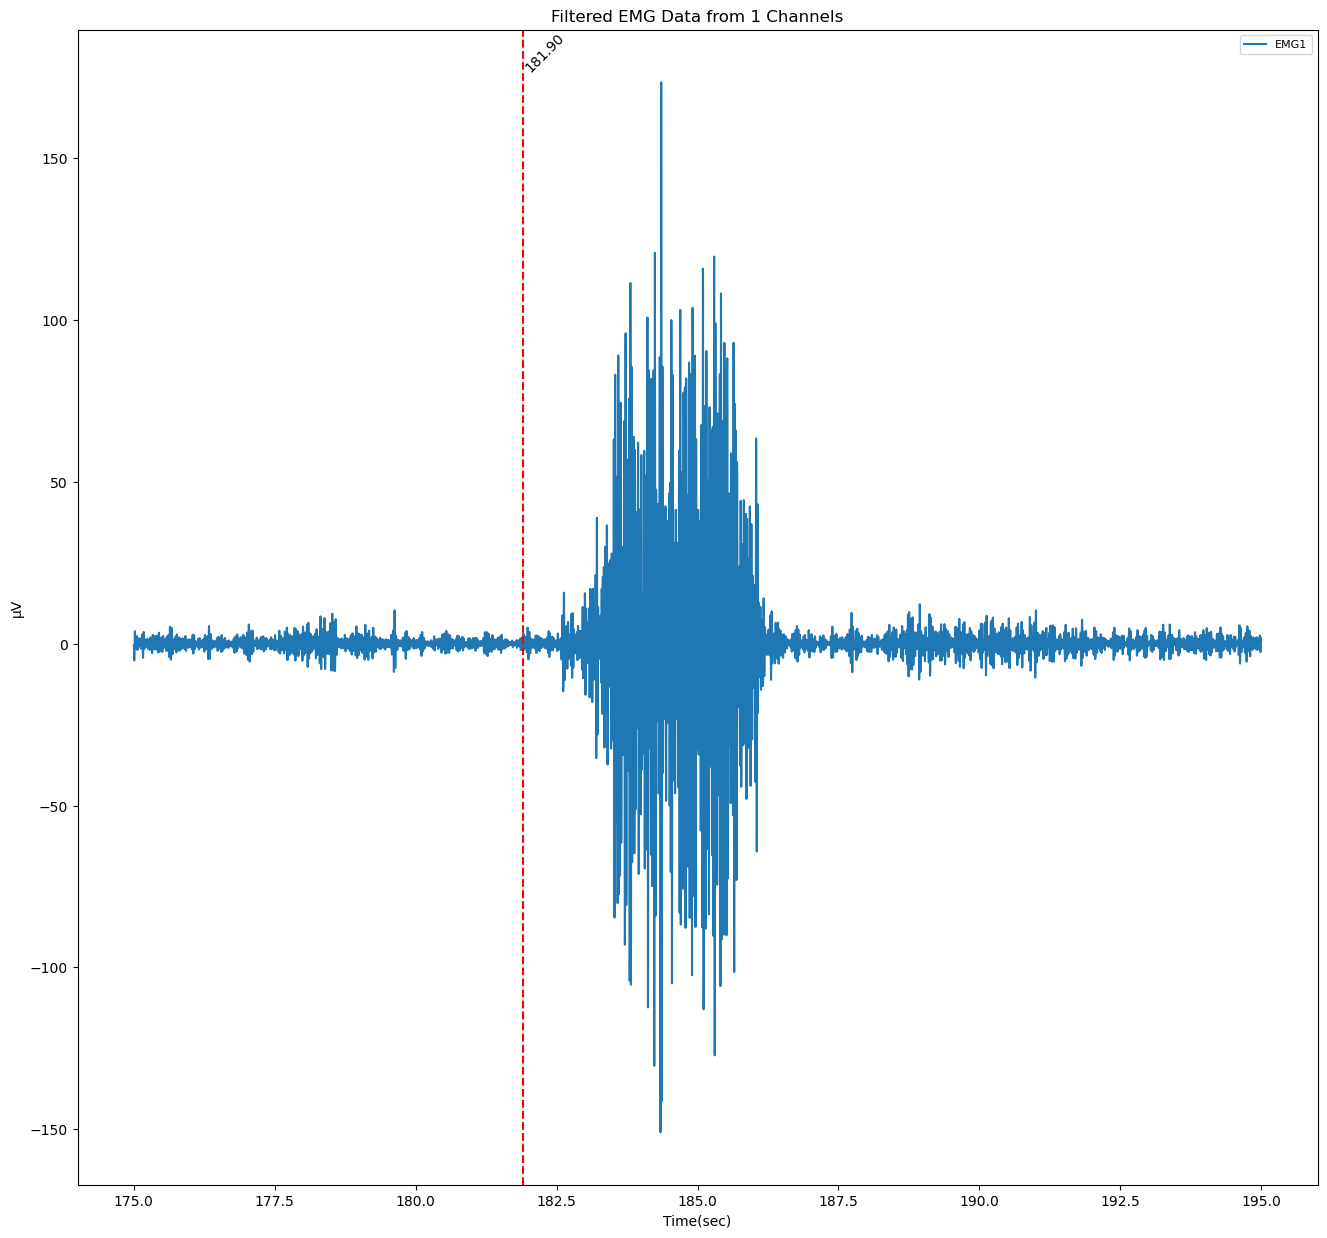

In [30]:
plotMNEData(mne_data=filtered_motor_emg, domain='time', scaling=1e6, plt_x_range=(175,195),
            title='Filtered EMG Data from %d Channels'%(len(filtered_motor_emg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            show_trigger=True, show_plt=True)

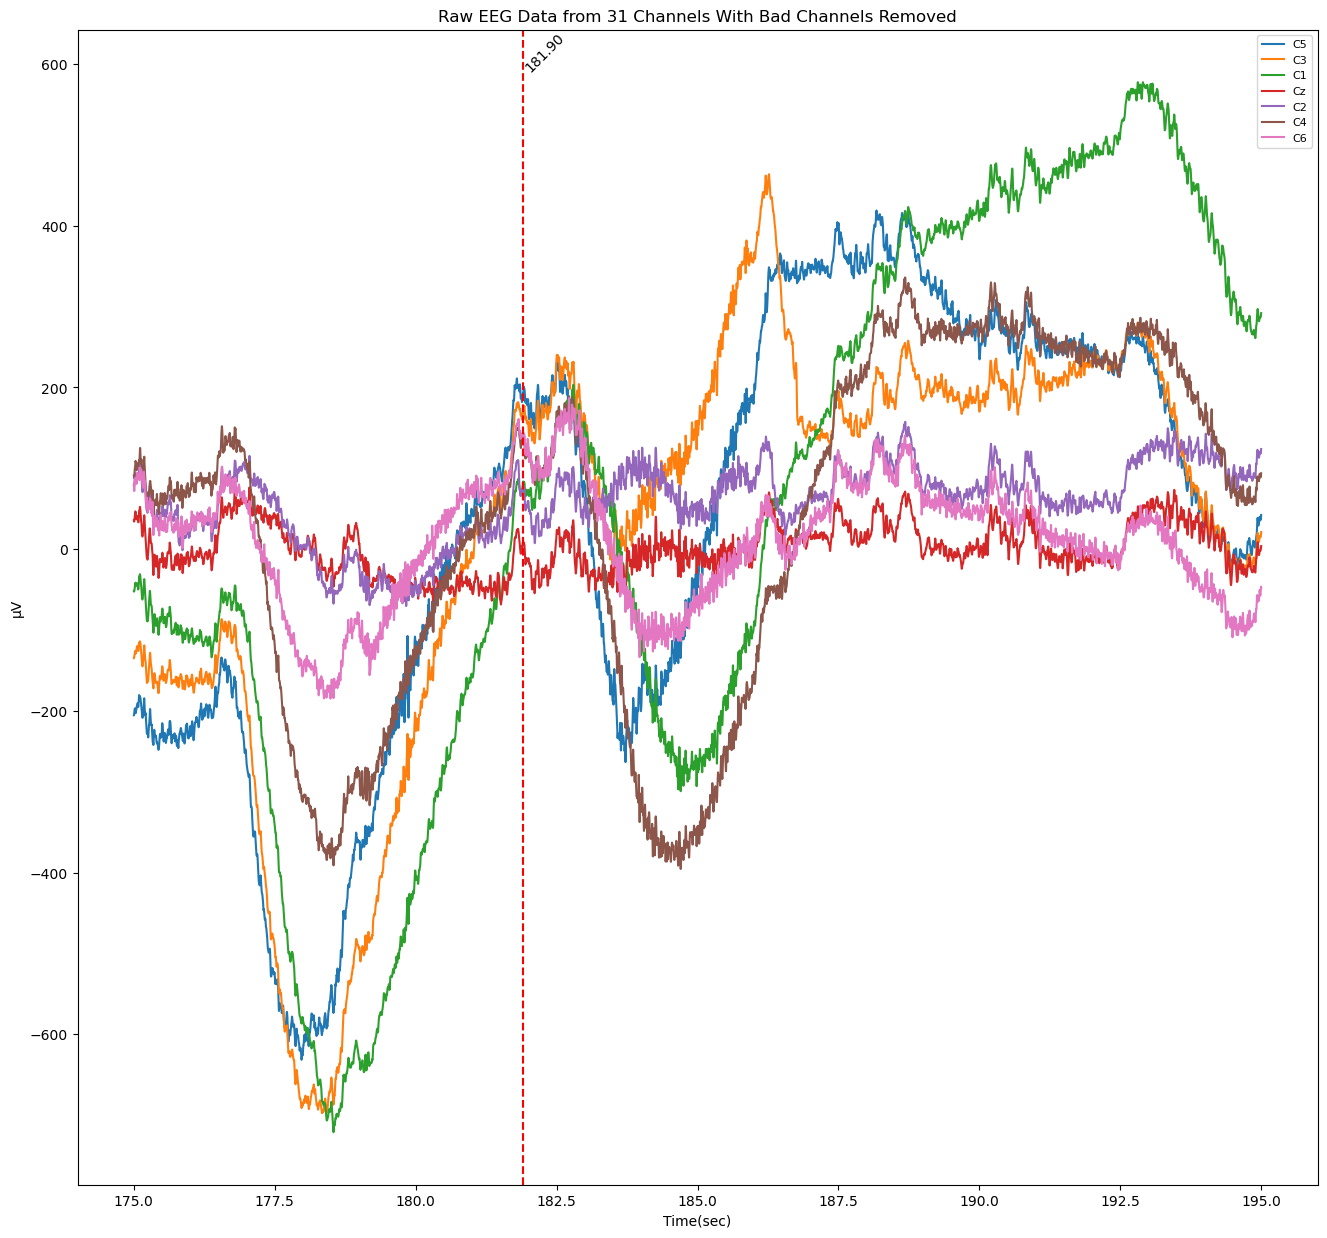

In [31]:
plotMNEData(mne_data=motor_eeg_wo_bad_ch, domain='time', scaling=1e6, plt_x_range=(175,195),
            title='Raw EEG Data from %d Channels With Bad Channels Removed'%(len(motor_eeg_wo_bad_ch.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            channels=['C5', 'C3', 'C1', 'Cz','C2', 'C4', 'C6'], show_param_ch=True, show_trigger=True, show_plt=True)

In [128]:
motor_eeg_tfr_df

time  freq  epoch  condition           Fp1           AF7  \
0      -1.000000   1.0      0  Neck_Left -2.217953e-08 -3.923345e-09   
1      -0.996094   1.0      0  Neck_Left -2.212560e-08 -3.801152e-09   
2      -0.992188   1.0      0  Neck_Left -2.206886e-08 -3.686763e-09   
3      -0.988281   1.0      0  Neck_Left -2.199725e-08 -3.580865e-09   
4      -0.984375   1.0      0  Neck_Left -2.189060e-08 -3.482256e-09   
...          ...   ...    ...        ...           ...           ...   
392185  1.984375  30.0     16  Neck_Left  1.005946e-08  5.736332e-09   
392186  1.988281  30.0     16  Neck_Left  1.026986e-08  5.840660e-09   
392187  1.992188  30.0     16  Neck_Left  1.026611e-08  5.853734e-09   
392188  1.996094  30.0     16  Neck_Left  1.001038e-08  5.727500e-09   
392189  2.000000  30.0     16  Neck_Left  9.472558e-09  5.472995e-09   

                 AF3           AF4           AF8            F7  ...  \
0       1.997922e-09 -3.894244e-09  2.797352e-08  1.236403e-09  ...   
1       2.047122e-09 -3.783037e-09  2.925152e-08  1.429459e-09  ...   
2       2.068368e-09 -3.701873e-09  3.052850e-08  1.618638e-09  ...   
3       2.063598e-09 -3.662480e-09  3.173127e-08  1.797918e-09  ...   
4       2.039776e-09 -3.664103e-09  3.280304e-08  1.961211e-09  ...   
...              ...           ...           ...           ...  ...   
392185  8.721300e-10  2.664853e-09  2.600609e-09  4.564210e-10  ...   
392186  9.370803e-10  2.723104e-09  2.631585e-09  4.457669e-10  ...   
392187  9.612069e-10  2.766989e-09  2.635459e-09  4.136196e-10  ...   
392188  9.230889e-10  2.765762e-09  2.623111e-09  3.752167e-10  ...   
392189  8.251590e-10  2.685907e-09  2.601912e-09  3.491108e-10  ...   

                 FT8            T7            C5            C3            C1  \
0      -4.689347e-09 -2.442512e-11  6.410902e-11 -2.496915e-09 -3.415663e-09   
1      -4.679870e-09 -3.214509e-11  1.844433e-10 -2.674442e-09 -3.754072e-09   
2      -4.679638e-09 -4.765662e-11  2.638482e-10 -2.884904e-09 -4.096025e-09   
3      -4.689522e-09 -6.388088e-11  3.256586e-10 -3.103419e-09 -4.421612e-09   
4      -4.704026e-09 -7.501197e-11  3.945569e-10 -3.306450e-09 -4.715546e-09   
...              ...           ...           ...           ...           ...   
392185  1.601077e-09  1.809875e-09  2.446037e-09  2.575291e-09  2.117981e-09   
392186  1.591137e-09  1.808200e-09  2.463766e-09  2.580601e-09  2.098806e-09   
392187  1.590851e-09  1.812230e-09  2.484977e-09  2.588991e-09  2.079068e-09   
392188  1.588059e-09  1.819134e-09  2.497004e-09  2.594515e-09  2.070661e-09   
392189  1.556642e-09  1.809669e-09  2.472471e-09  2.572847e-09  2.061607e-09   

                  Cz            C2            C4            C6            T8  
0      -2.170451e-09 -2.686321e-09 -4.379346e-09 -3.735245e-09  4.828739e-09  
1      -2.077693e-09 -2.777597e-09 -4.436186e-09 -3.755007e-09  5.113595e-09  
2      -2.001789e-09 -2.877595e-09 -4.493156e-09 -3.775091e-09  5.399613e-09  
3      -1.929047e-09 -2.972710e-09 -4.540400e-09 -3.789716e-09  5.669436e-09  
4      -1.848433e-09 -3.053460e-09 -4.573383e-09 -3.796639e-09  5.909182e-09  
...              ...           ...           ...           ...           ...  
392185  1.819217e-09  1.734020e-09  2.340952e-09  1.940870e-09  5.485992e-10  
392186  1.798102e-09  1.713040e-09  2.314201e-09  1.934335e-09  5.524045e-10  
392187  1.778190e-09  1.691335e-09  2.286855e-09  1.932833e-09  5.721874e-10  
392188  1.771204e-09  1.681569e-09  2.271700e-09  1.934574e-09  6.038837e-10  
392189  1.765882e-09  1.674181e-09  2.254805e-09  1.919078e-09  6.370100e-10  

[392190 rows x 34 columns]

In [140]:
(motor_eeg_tfr_df[(motor_eeg_tfr_df['time'] < 1.5) & (motor_eeg_tfr_df['time'] > 0.5) 
                 & (motor_eeg_tfr_df['epoch'] == 0) & (motor_eeg_tfr_df['freq'] == 1.0)].iloc[2]['time'] - 
 motor_eeg_tfr_df[(motor_eeg_tfr_df['time'] < 1.5) & (motor_eeg_tfr_df['time'] > 0.5) 
                 & (motor_eeg_tfr_df['epoch'] == 0) & (motor_eeg_tfr_df['freq'] == 1.0)].iloc[3]['time'])

-0.00390625